<h1>Table of Contents<span class="tocSkip"></span></h1>

[Introduction and Business Case](#SI)

[1. Imports and Preliminary Exploration](#S1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.1 Memory Optimization](#S1.1)

[2. EDA & Data Preprocessing](#S2)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Univariate Analyses](#S2.1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Multivariate Analyses](#S2.2)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3 Outliers](#S2.3)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4 Final Data Preprocessing](#S2.4)

[3. Spectral Clustering for segmenting Clients](#S3)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1 Spectral Clustering from Scratch](#S3.1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2 Spectral Clustering based on k-NN graph for segmenting customers](#S3.2)

[4. Clusters Interpretation](#S4)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1 Conclusion](#S4.1)

[5. Limitations](#S5)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1 Endogeneity](#S5.1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1 Final Remarks](#S5.2)

[6. References](#S6)

**UX Note**

For a better user experience, I recommend to visualize this Notebook on [Jupyter Notebook Viewer](https://nbviewer.jupyter.org/github/dafo16ac/BI_Market_Segmentation_v1.0/blob/main/BI_Market_Segmentation_Part1_v1.0.ipynb?flush_cache=true), or on [Binder](https://mybinder.org/v2/gh/dafo16ac/BI_Market_Segmentation_v1.0/main?filepath=BI_Market_Segmentation_Part1_v1.0.ipynb), if not already.

<a id='SI'></a>
<h1>Introduction and Business Case <span class="tocSkip"></span></h1>


This Notebook is the first of a three-part series focused on Business Intelligence in the hospitality industry, and it has the purpose of identifying the best market segments for a hospitality business via spectral clustering based on customer revenues and satisfaction scores.
This first notebook has been an opportunity to showcase my reasoning on assumptions and first principles, and to showcase my abilities in Data Science techniques (namely Data Preprocessing and Clustering). Being introductory in its purpose, sometimes I take the opportunity to explain concepts and procedures.

I decided to focus on this industry because I have been working in hospitality for several years, both in close contact with clients and by closely observing trends.

It is based on an anonymized and partly synthetic dataset of hotel’s clients during the period between 07-2016 and 12-2016.


-----

<h3>Further development: Web Application<span class="tocSkip"></span></h3>

Furthermore, I have developed and deployed a web application at the [following link](https://business-intelligence-davide.herokuapp.com/). It has a business intelligence setting and relies on the output of the current notebook. Its code can be found at my [Github repository](https://github.com/dafo16ac/business-intelligence-df-2.2).


-----

<h3>The problem that the current Business Case is aiming to solve is:<span class="tocSkip"></span></h3>


<div class="alert alert-warning" style = "border-radius:10px;border-width:3px;border-color:darkyellow;font-size:16px;"> 
How to increase hotels' revenues, being constrained by the maximum number of guests that can be hosted?
</div>


Considerations on the sources of revenues in a hotel:
-	1) Rental revenues earned from occupied rooms are determined by quantity and prices, as average rental revenue earned from an occupied room per day (i.e. ADR)
    - the quantity supply of rooms is constrained by an upper ceiling
    - in the short term, the price is the only element that can be adjusted
    - customers have a greater price acceptance for products or services providing greater satisfaction [[0]](#R0) <a id="r0"></a>

> **KEY CONSIDERATION**: *The ability to charge higher prices, all else equal, depends on customer satisfaction and on the consequent longer-term brand perception/reputation, e.g. on social media platform. Those preferences are subjective*

-	2) in-house additional expenditures on services and goods such as in restaurants, bars, extras, etc, assume an ever-increasing importance as an additional stream of revenues

> **KEY CONSIDERATION**: *Not all customers are willing to spend more on additional goods and services, some more than others*

-----


<h3>In order to increase overall revenue streams by charging higher prices, the designed solution is:<span class="tocSkip"></span></h3>

<div class="alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-size:16px;"> 
<p>
Development of a model that profiles those guests most satisfied and most willing to spend. The two features of the model are: (1) daily revenues (as sum of daily in-house additional expenditures and average daily rates revenues), and (2) customer satisfaction ratings as recorded in proprietary databases.
    </p>
</div>


<h3>The Cluster Profiles:<span class="tocSkip"></span></h3>


The model generates seven clusters (i.e. the segments) by levels of daily revenues stream and satisfaction scores. As I will show in Section 4, the clusters are labeled in the following way:


- 0. `High Revenue Stream - High Customer Satisfaction`

- 1. `High Revenue Stream - Low Customer Satisfaction`

- 2. `Low Revenue Stream - High Customer Satisfaction`

- 3. `Low Revenue Stream - Low Customer Satisfaction`

- 4. `Low Revenue Stream - Medium Customer Satisfaction`

- 5. `Medium Revenue Stream - Low Customer Satisfaction`

- 6. `Medium Revenue Stream - Medium Customer Satisfaction`

  
*The above labels highlight the core characteristics of the clusters that management, marketing, and operations departments will decide to target and to shape strategies on. A proof-of-concept tool that they can use for that purpose is the above mentioned [web application](https://business-intelligence-davide.herokuapp.com/) that I have developed and deployed.* 

<img src="plot_clusters.png">

<a id='S1'></a>
<h1>1. Imports and Preliminary Exploration <span class="tocSkip"></span></h1>

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from scipy.stats import gaussian_kde, boxcox
import statsmodels.api as sm
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import minmax_scale
from sklearn.cluster import KMeans, SpectralClustering

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

## Settings
# autoreload changes in custom modules
%load_ext autoreload
%autoreload 2

# Exclude no-life-threatening warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning) 

# Styling the outputs
from IPython.display import Markdown as md
pd.options.display.max_columns = 50
pd.options.display.max_rows = 85
%matplotlib inline
sns.set_style('darkgrid', {'axes.facecolor': '.9'})

In [2]:
""" Parameters Settings """
NUM_SAMPLE = 59607  # Max is 59607. Smaller size helps for faster computation during development

In [3]:
hotel = pd.read_csv("hotel.csv")
hotel = hotel.sample(n=NUM_SAMPLE, random_state=42)
hotel.sort_values('Arrival Date', inplace=True)
hotel = hotel.reset_index(drop=True)

**Dataset**

In [4]:
hotel.head()

IsCanceled  LeadTime  Adults  Children  Babies       Meal  \
0           0       148       2       0.0       0  BB          
1           0       462       2       0.0       0  BB          
2           1       187       2       0.0       0  HB          
3           0        39       2       0.0       0  SC          
4           0         0       3       1.0       0  BB          

              Country Travelling Group Distribution Channel  \
0               Spain          Couples                TA/TO   
1      United Kingdom           Groups                TA/TO   
2  Russian Federation          Couples                TA/TO   
3             Denmark          Couples                TA/TO   
4             Denmark           Family               Direct   

   Is Repeated Guest  Previous Cancellation  Previous Bookings Not Cancelled  \
0                  0                      0                                0   
1                  0                      0                                0   
2                  0                      0                                0   
3                  0                      0                                0   
4                  0                      0                                0   

  Reserved Room Type Assigned Room Type  Booking Changes     Deposit Type  \
0   A                  A                               0  No Deposit        
1   A                  A                               0  No Deposit        
2   D                  D                               0  No Deposit        
3   A                  A                               0  No Deposit        
4   A                  E                               0  No Deposit        

         Agent      Company    Customer Type  Required Car Parking Spaces  \
0            9         NULL  Transient-Party                            0   
1          229         NULL  Transient-Party                            0   
2            9         NULL        Transient                            0   
3            9         NULL        Transient                            0   
4         NULL         NULL        Transient                            0   

   # Special Requests Reservation Status   Age  Nights      ADR     Bar  \
0                   2          Check-Out  32.0       8  4525.94  2080.0   
1                   1          Check-Out  33.0       3  5182.82   812.0   
2                   3           Canceled  66.0       1  6334.20   272.0   
3                   1          Check-Out  77.0       1  4926.60   206.0   
4                   0          Check-Out  48.0       1  8556.00   315.0   

   Restaurant  Breakfast  Other  Additional Expenditures Arrival Date  \
0      6048.0      525.0   66.0                   8719.0   2016-07-01   
1      2096.0      304.0   53.0                   3265.0   2016-07-01   
2       654.0      101.0   42.0                   1069.0   2016-07-01   
3       688.0       88.0   48.0                   1030.0   2016-07-01   
4      1193.0      221.0   92.0                   1821.0   2016-07-01   

   Customer Satisfaction Rating  
0                      3.183611  
1                      7.617953  
2                           NaN  
3                      7.366193  
4                      8.448644

In [5]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59607 entries, 0 to 59606
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   IsCanceled                       59607 non-null  int64  
 1   LeadTime                         59607 non-null  int64  
 2   Adults                           59607 non-null  int64  
 3   Children                         59605 non-null  float64
 4   Babies                           59607 non-null  int64  
 5   Meal                             59607 non-null  object 
 6   Country                          59607 non-null  object 
 7   Travelling Group                 59607 non-null  object 
 8   Distribution Channel             59607 non-null  object 
 9   Is Repeated Guest                59607 non-null  int64  
 10  Previous Cancellation            59607 non-null  int64  
 11  Previous Bookings Not Cancelled  59607 non-null  int64  
 12  Reserved Room Type

In [6]:
hotel.describe()

IsCanceled      LeadTime        Adults      Children        Babies  \
count  59607.000000  59607.000000  59607.000000  59605.000000  59607.000000   
mean       0.430335    109.692385      1.844683      0.280362      0.004899   
std        0.495127    110.747810      0.521363      0.492134      0.070775   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000     23.000000      2.000000      0.000000      0.000000   
50%        0.000000     74.000000      2.000000      0.000000      0.000000   
75%        1.000000    164.000000      2.000000      1.000000      0.000000   
max        1.000000    629.000000      4.000000      3.000000      2.000000   

       Is Repeated Guest  Previous Cancellation  \
count       59607.000000           59607.000000   
mean            0.025534               0.079622   
std             0.157741               0.417950   
min             0.000000               0.000000   
25%             0.000000               0.000000   
50%             0.000000               0.000000   
75%             0.000000               0.000000   
max             1.000000              13.000000   

       Previous Bookings Not Cancelled  Booking Changes  \
count                     59607.000000     59607.000000   
mean                          0.139698         0.187981   
std                           1.786173         0.604825   
min                           0.000000         0.000000   
25%                           0.000000         0.000000   
50%                           0.000000         0.000000   
75%                           0.000000         0.000000   
max                          72.000000        16.000000   

       Required Car Parking Spaces  # Special Requests           Age  \
count                 59607.000000        59607.000000  59607.000000   
mean                      0.023940            0.550070     39.410724   
std                       0.153849            0.782084     13.312774   
min                       0.000000            0.000000      2.000000   
25%                       0.000000            0.000000     30.000000   
50%                       0.000000            0.000000     37.000000   
75%                       0.000000            1.000000     47.000000   
max                       3.000000            5.000000    101.000000   

             Nights            ADR           Bar    Restaurant     Breakfast  \
count  59607.000000   59607.000000  59607.000000  59605.000000  59605.000000   
mean       2.976865    4842.085289    614.325532   1966.135626    317.828202   
std        1.866574    2063.896316    450.849916   1446.196492    259.837537   
min        0.000000       0.000000      0.000000      0.000000   -166.000000   
25%        2.000000    3643.200000    302.000000   1009.000000    145.000000   
50%        3.000000    4577.000000    523.000000   1730.000000    259.000000   
75%        4.000000    5796.000000    805.000000   2559.000000    416.000000   
max       57.000000  248400.000000  11972.000000  32424.000000   7589.000000   

              Other  Additional Expenditures  Customer Satisfaction Rating  
count  59605.000000             59605.000000                  33956.000000  
mean      44.721349              2943.015267                      6.486065  
std       16.711959              2112.691817                      1.811782  
min        0.000000                 0.000000                      0.003017  
25%       33.000000              1515.000000                      5.257330  
50%       45.000000              2593.000000                      6.599112  
75%       55.000000              3826.000000                      7.828275  
max      145.000000             50337.000000                      9.999830

<a id='S1.1'></a>
<h2>1.1 Memory Optimization <span class="tocSkip"></span></h2>

For reducing time and memory required by the models, I have previously built a function that optimizes the data format according to variables characteristics. In this case, being only 32 features and 59607 entries, it is not strictly necessary to proceed. Yet, it is a good practice that I stick to. Furthermore, as a side product, it also pre-checks whether all the values in each columns are either all integer/float/strings. If that is not the case, it raises a warning and I can investigate the issue.

*Caveat*: in the coming model I deem not to need a high level of precision of the current `float64` variables. If that were the case, I would proceed differently.

In [7]:
# FIX could be used to simplify the optimize function
len(hotel.loc[~hotel['Assigned Room Type'].str.isdigit(), 'Assigned Room Type'])

59607

In [8]:
## Function to optimize the format of the features
def optimize_memory(df):
    for col in df.columns:
        number = 0
        strings = 0
        for i in df[col]: 
            if (type(i) == int) | (type(i) == float): number += 1
            elif (type(i) == str): strings += 1
            else: pass
            
        if number == len(df[col]):
            integer = 0
            for i in df[col]: 
                if i % 1 == 0: integer += 1
                else: pass
            if (df[col].max()<128) & (df[col].min()>=-128) & (integer==len(df[col])): 
                df[col] = df[col].astype('int8')
            elif (df[col].max()<128) & (df[col].min()>=-128) & (integer!=len(df[col])): 
                df[col] = df[col].astype('float16')
            elif (df[col].max()<32768) & (df[col].min()>=-32768) & (integer==len(df[col])): 
                df[col] = df[col].astype('int32')
            elif (df[col].max()<32768) & (df[col].min()>=-32768) & (integer!=len(df[col])): 
                df[col] = df[col].astype('float32')
            elif (df[col].max()>=32768) & (df[col].min()<-32768) & (integer==len(df[col])): 
                df[col] = df[col].astype('int64')
            elif (df[col].max()>=32768) & (df[col].min()<-32768) & (integer!=len(df[col])): 
                df[col] = df[col].astype('float64')
        
        elif strings == len(df[col]): pass
        
        else: print('Explore the dataset, there are cases not contemplated and/or irregularities')
            
    return df

hotel = optimize_memory(hotel)

In [9]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59607 entries, 0 to 59606
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   IsCanceled                       59607 non-null  int8   
 1   LeadTime                         59607 non-null  int32  
 2   Adults                           59607 non-null  int8   
 3   Children                         59605 non-null  float16
 4   Babies                           59607 non-null  int8   
 5   Meal                             59607 non-null  object 
 6   Country                          59607 non-null  object 
 7   Travelling Group                 59607 non-null  object 
 8   Distribution Channel             59607 non-null  object 
 9   Is Repeated Guest                59607 non-null  int8   
 10  Previous Cancellation            59607 non-null  int8   
 11  Previous Bookings Not Cancelled  59607 non-null  int8   
 12  Reserved Room Type

<a id='S2'></a>
<h1>2. EDA & Data Preprocessing <span class="tocSkip"></span></h1>

The next step is to check and validate the data for anomalies, outliers, missing values, and feature scaling. In this Notebook EDA is focused only on the 2 main features used in the spectral clustering model (i.e. `ADR Adjusted` and `Customer satisfaction rating`). Autonomous exploration of the relevant variables is possible via the [web application](https://business-intelligence-davide.herokuapp.com/) I developed, and further EDA will be executed in the coming Notebook Part 2.

----

The structure of this Section is as follows:

- Univariate Analysis both for `Customer Satisfaction Rating` and `ADR Adjusted`:
    - missing values
    - 0 and infinite values
    - distribution
- Multivariate Analyses:
    - correlation
    - scatterplots and KDE
- Outliers:
    - univariate outliers
    - multivariate: Isolation Forest
- Final Data Preprocessing:
    - feature scaling
    - final memory optimization
    
    
-----

**Definitions of the key Features**

| Feature | Description
| ----- | ---------- 
| `Customer Satisfaction Rating` | Average of the six satisfaction ratings that the clients have provided after the check-out regarding their experience (0 - 10 stars, steps of 0.5).
| `ADR`: Average Daily Rate | Daily rate of each room as average over the whole period, calculated taking into consideration all the persons staying in the room (DKK)
| `Additional Expenditures` | Sum of all extra expenditures of the clients staying in a same room over their entire staying (DKK). It includes the services provided directly by the hotel, hence affecting the top line.
| `ADR Adjusted` (extracted) | ADR plus the daily average of extra expenditures of all the persons staying in the room (DKK)

<a id='S2.1'></a>
<h2>2.1 Univariate Analyses <span class="tocSkip"></span></h2>

**Missing Values**

They can be categorized into three main types:
- Missing completely at random (MCAR) - missing values are randomly distributed across all observations. It can be assumed when on a *t*-test comparing two parts of data there is no difference in means between the two samples
- Missing at random (MAR) - differently from MCAR, data is missing randomly only within sub-samples of data
- Missing not at random (MNAR) - missing data has a structure that determines it so.


Regarding **MCAR** and **MAR**, they can be treated with several methodologies but they always need to be analyzed case by case. On a general level, the most common approaches to treat *cross-sectional missing values* are:

1. simple *deletion* of the rows with missing values. Reasonable if the percentage is insignificant, otherwise better solutions are needed
2. *Univariate statistic imputation*: it implies using the statistics (mean, median or most frequent) of each column in which the missing values are located, or zero/constant values. Simple, but it doesn’t factor the correlations between features, hence not very accurate. For categorical features only use "most frequent" or zero values
4. *Multivariate feature imputation*, also called iterative imputation: it implies value estimated by another predictive model which models each feature with missing values as a function of other features, and uses that estimate for imputation. Each feature is imputed sequentially, one after the other, allowing prior imputed values to be used as part of a model in predicting subsequent features [[1]](#R1)<a id="r1"></a>. Overall, these are more accurate, but also they tend to be computationally expensive and each keeps idiosyncratic limitations. Examples are:
    - K-Nearest Neighbours
    - linear regressions (generally called Multivariate Imputation by Chained Equations, MICE)
    - Expectation Maximization[fix https://impyute.readthedocs.io/en/master/index.html]
    - random forest

Lastly, regarding **MNAR**, given that an underlying common cause has been found that determines the reason for which a data entry is missing, requires even more a specific assessment on how to proceed treating the missing values on a case-by-case basis.

**Distribution**

A normal or normal-like distribution allows to apply parametric methods, for example for determining outliers (e.g. the standard deviation method). Since the distribution tests resulted in the distribution being not normal (Anderson-Darling, D’Agostino’s K<sup>2</sup>), I don't show here the tests to keep the notebook lean. 

Common tools for checking normality *visually* are the frequency distribution (histogram), stem-and-leaf plot, boxplot, P-P plot (probability-probability plot), and Q-Q plot (quantile-quantile plot). The visual approach does not guarantee that the distribution is normal, but histogram and Q-Q plots are displayed to briefly substantiate the claim of non-normality. Yet, it can help in spotting anomalies and for having hints on the data distribution.

An important consequence of the non-normality is that I will apply non-parametric methods for detecting outliers, e.g. the Tuckey method [[2]](#R2)<a id="r2"></a>, even though the sample size could be considered large enough to not cause major problems for adopting parametric methods nonetheless.


----

<h3>2.1.1 Customer Satisfaction Rating <span class="tocSkip"></span></h3>

**Missing Values: MNAR**

MNAR values are quite relevant for the `Customer Satisfaction Rating` variable. That is because the `IsCanceled` variable signals a canceled booking if the value is equal to 1. In fact, a booking being canceled makes the staying non-existent, subsequently there cannot be any satisfaction rate related to it.

Hence, I will proceed to *remove* the corresponding entries of the canceled orders from the dataset because they are not important relative to the discovery neither of revenue stream nor of satisfaction at the hotel. Nonetheless, I will save the removed values in another dataframe, because they still convey important information. Later, in Part 3, I will predict whether a customer is going to cancel the booking and possibly consider it as a cluster.

In [71]:
hotel['IsCanceled'].sum()

0

In [11]:
canceled_hotel = hotel.loc[hotel['IsCanceled']==1].copy()
canceled_hotel['Cluster'] = '-1'  # for using it in the next Part
canceled_hotel['IsCanceled'].sum()

25651

In [ ]:
canceled_hotel.to_csv("hotel_canceled.csv")
del canceled_hotel

In [12]:
# drop the records with missing data
hotel = hotel.loc[~hotel['IsCanceled'].isnull()].copy()
hotel = hotel.loc[hotel['IsCanceled']==0].copy()
print(hotel['IsCanceled'].sum())
print(hotel['IsCanceled'].isnull().sum())

0
0


In [13]:
# Quick check of NaN and inf values
md("There are {} null values and {} inf values in the `Customer Satisfaction Rating` variable".format(hotel['Customer Satisfaction Rating'].isnull().sum(), 
                                                                             hotel['Customer Satisfaction Rating'].isin([np.inf]).sum()))

There are 0 null values and 0 inf values in the `Customer Satisfaction Rating` variable

There are neither MCAR nor MAR left in this case, unsurprising given that the dataset came this way.

**Histogram plot**

I use the histogram as a simple check of the distribution of the sample data.

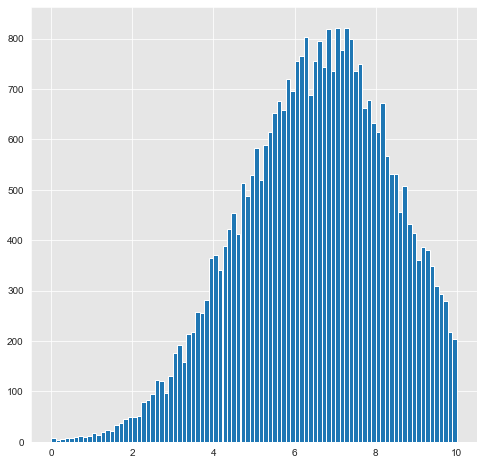

In [14]:
plt.figure(figsize=(8, 8))
hotel['Customer Satisfaction Rating'].hist(bins=90)

*Observation*: The graph doesn't show exactly a bell shape characteristic of a Gaussian distribution, rather a negatively skewed distribution.


-----

**Q-Q plot**

This plot plots the data against its own generated sample from the idealized distribution that it is compared with, in this case the Gaussian distribution, at the same cumulative distribution.

A perfect match for the distribution will be shown by a line of blue dots on the red line with a 45-degree angle from the bottom left of the plot to the top right, indicating a normal distribution (in this case).

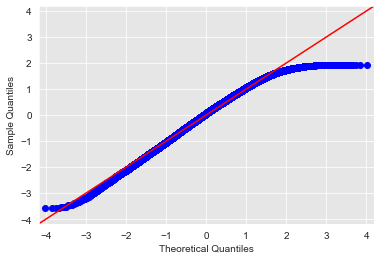

In [15]:
qq_csr = sm.qqplot(hotel['Customer Satisfaction Rating'], fit=True, line='45')

*Observation*: The blue dots deviated from the red line show a deviation from the expected normal distribution. Since they are quite a few, I can confidently say `Customer Satisfaction Rating` is not normally distributed.

----

<h3>2.1.2 ADR Adjusted <span class="tocSkip"></span></h3>

Before assessing the revenues distribution I need to account for additional expenditures as part of the revenue stream coming from the ADR. That means extracting a new variable called `ADR Adjusted`, by summing `ADR` and the daily average of `Additional Expenditures`. The new feature expresses the overall daily revenue average stream coming from a room.

In [16]:
# Quick check of NaN and inf values
md("There are {} null values and {} inf values in the `ADR` variable".format(hotel['ADR'].isnull().sum(), 
                                                                             hotel['ADR'].isin([np.inf]).sum()))

There are 0 null values and 0 inf values in the `ADR` variable

No further action needed regarding 0s and inf values.

<h4>Nights <span class="tocSkip"></span></h4>

In [17]:
## Quick Check of Nights values
md("There are {} null values and {} inf values in the `Nights` variable".
   format(hotel['Nights'].isnull().sum(),
          hotel['Nights'].isin([np.inf]).sum()))

There are 0 null values and 0 inf values in the `Nights` variable

In [18]:
hotel.loc[hotel['Nights']==0]

Empty DataFrame
Columns: [IsCanceled, LeadTime, Adults, Children, Babies, Meal, Country, Travelling Group, Distribution Channel, Is Repeated Guest, Previous Cancellation, Previous Bookings Not Cancelled, Reserved Room Type, Assigned Room Type, Booking Changes, Deposit Type, Agent, Company, Customer Type, Required Car Parking Spaces, # Special Requests, Reservation Status, Age, Nights, ADR, Bar, Restaurant, Breakfast, Other, Additional Expenditures, Arrival Date, Customer Satisfaction Rating]
Index: []

No further action needed regarding `Nights`'s 0/null/inf values.

----

Checking for and removing outliers for `Nights` larger than 14, given that extended stays are not reported as being customary:

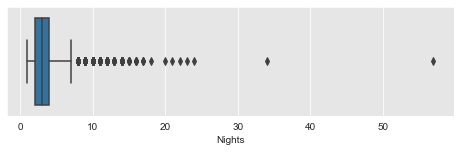

In [19]:
plt.figure(figsize=(8, 2))
sns.boxplot(x=hotel['Nights'])

In [20]:
overnights = hotel.loc[hotel['Nights']>14]
overnights

IsCanceled  LeadTime  Adults  Children  Babies       Meal  \
1242            0         1       2       0.0       0  BB          
1743            0        82       2       0.0       0  SC          
2737            0         6       2       0.0       0  BB          
5071            0       121       2       0.0       0  BB          
7013            0       308       2       0.0       0  BB          
7050            0         5       2       1.0       0  BB          
7205            0       308       2       1.0       0  BB          
8504            0       152       3       1.0       0  HB          
9462            0         0       1       0.0       0  BB          
12040           0       165       1       0.0       0  BB          
22377           0        42       2       1.0       0  BB          
23616           0        12       2       1.0       1  BB          
26946           0       140       0       0.0       0  SC          
37066           0         2       1       0.0       0  BB          
44564           0         5       1       0.0       0  BB          
45454           0         3       2       0.0       0  BB          
52954           0         3       1       1.0       0  BB          
52972           0         3       1       0.0       0  BB          
53032           0        11       1       0.0       0  BB          
53082           0         3       1       0.0       0  BB          
53231           0        11       1       0.0       0  BB          
54984           0       223       2       0.0       0  SC          

              Country Travelling Group Distribution Channel  \
1242          Denmark          Couples               Direct   
1743           Brazil          Couples                TA/TO   
2737          Denmark          Couples                TA/TO   
5071     Saudi Arabia          Couples                TA/TO   
7013          Germany          Couples                TA/TO   
7050           Angola           Family                TA/TO   
7205          Germany           Family                TA/TO   
8504           France           Family                TA/TO   
9462           Sweden          Couples               Direct   
12040         Denmark         Business            Corporate   
22377          Brazil           Family                TA/TO   
23616          Angola           Family                TA/TO   
26946  United Kingdom          Couples                TA/TO   
37066           Japan         Business            Corporate   
44564          Greece          Couples            Corporate   
45454         Denmark         Business            Corporate   
52954         Croatia           Family            Corporate   
52972          France         Business            Corporate   
53032          France          Couples            Corporate   
53082         Ireland          Couples            Corporate   
53231          France         Business            Corporate   
54984          Sweden          Couples                TA/TO   

       Is Repeated Guest  Previous Cancellation  \
1242                   0                      0   
1743                   0                      0   
2737                   0                      0   
5071                   0                      0   
7013                   0                      0   
7050                   0                      0   
7205                   0                      0   
8504                   0                      0   
9462                   0                      0   
12040                  0                      0   
22377                  0                      0   
23616                  0                      0   
26946                  0                      0   
37066                  0                      0   
44564                  0                      0   
45454                  0                      0   
52954                  0                      0   
52972                  0                      0   
53032                  

In [21]:
hotel = hotel.drop(overnights.index, axis=0)
hotel

IsCanceled  LeadTime  Adults  Children  Babies       Meal  \
0               0       148       2       0.0       0  BB          
1               0       462       2       0.0       0  BB          
3               0        39       2       0.0       0  SC          
4               0         0       3       1.0       0  BB          
6               0        82       2       0.0       0  BB          
...           ...       ...     ...       ...     ...        ...   
59599           0        55       1       0.0       0  BB          
59601           0        54       1       0.0       0  BB          
59602           0         0       2       1.0       0  BB          
59603           0        43       2       0.0       0  BB          
59605           0       103       2       0.0       0  BB          

              Country Travelling Group Distribution Channel  \
0               Spain          Couples                TA/TO   
1      United Kingdom           Groups                TA/TO   
3             Denmark          Couples                TA/TO   
4             Denmark           Family               Direct   
6             Belgium          Couples                TA/TO   
...               ...              ...                  ...   
59599          France          Couples                TA/TO   
59601          France          Couples                TA/TO   
59602     Switzerland           Family               Direct   
59603          France          Couples                TA/TO   
59605          France          Couples                TA/TO   

       Is Repeated Guest  Previous Cancellation  \
0                      0                      0   
1                      0                      0   
3                      0                      0   
4                      0                      0   
6                      0                      0   
...                  ...                    ...   
59599                  0                      0   
59601                  0                      0   
59602                  1                      0   
59603                  0                      0   
59605                  0                      0   

       Previous Bookings Not Cancelled Reserved Room Type Assigned Room Type  \
0                                    0   A                  A                  
1                                    0   A                  A                  
3                                    0   A                  A                  
4                                    0   A                  E                  
6                                    0   A                  A                  
...                                ...                ...                ...   
59599                                0   A                  A                  
59601                                0   A                  A                  
59602                                0   D                  D                  
59603                                0   A                  A                  
59605                                0   A                  A                  

       Booking Changes     Deposit Type        Agent      Company  \
0                    0  No Deposit                 9         NULL   
1                    0  No Deposit               229         NULL   
3                    0  No Deposit                 9         NULL   
4                    0  No Deposit              NULL         NULL   
6                    0  No Deposit                 9         NULL   
...                ...              ...          ...          ...   
59599                0  No Deposit               104         NULL   
59601                0  No Deposit               104         NULL   
59602                2  No Deposit              NULL         NULL   
59603                0  No Deposit               104         NULL   
59605                0  No Deposit                28         NULL   

         Customer Type  Requir

<h4>Additional Expenditures <span class="tocSkip"></span></h4>

Checking for and removing outliers of `Additional Expenditures`

In [22]:
## Quick Check of Additional Expenditures values
md("There are {} null values and {} inf values in the `Additional Expenditures` variable".
   format(hotel['Additional Expenditures'].isnull().sum(),
          hotel['Additional Expenditures'].isin([np.inf]).sum()))

There are 0 null values and 0 inf values in the `Additional Expenditures` variable

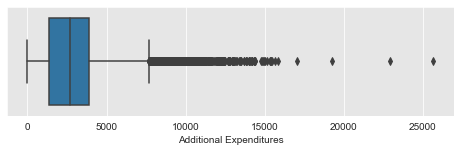

In [23]:
plt.figure(figsize=(8, 2))
sns.boxplot(x=hotel['Additional Expenditures'])

In [24]:
add_expenditures = hotel.loc[hotel['Additional Expenditures']>20000]
add_expenditures

IsCanceled  LeadTime  Adults  Children  Babies       Meal  Country  \
770           0        28       3       1.0       0  BB          Angola   
880           0       182       3       1.0       0  BB         Denmark   

    Travelling Group Distribution Channel  Is Repeated Guest  \
770           Family                TA/TO                  0   
880           Family                TA/TO                  0   

     Previous Cancellation  Previous Bookings Not Cancelled  \
770                      0                                0   
880                      0                                0   

    Reserved Room Type Assigned Room Type  Booking Changes     Deposit Type  \
770   D                  D                               0  No Deposit        
880   D                  D                               3  No Deposit        

           Agent      Company Customer Type  Required Car Parking Spaces  \
770            9         NULL     Transient                            0   
880            9         NULL     Transient                            0   

     # Special Requests Reservation Status  Age  Nights     ADR   Bar  \
770                   1          Check-Out   40      14  6021.4  3761   
880                   1          Check-Out   38      14  6803.4  5774   

     Restaurant  Breakfast  Other  Additional Expenditures Arrival Date  \
770     16875.0     2221.0   79.0                  22936.0   2016-07-03   
880     16986.0     2824.0   71.0                  25655.0   2016-07-03   

     Customer Satisfaction Rating  
770                      8.984375  
880                      8.343750

In [25]:
hotel = hotel.drop(add_expenditures.index, axis=0)
hotel

IsCanceled  LeadTime  Adults  Children  Babies       Meal  \
0               0       148       2       0.0       0  BB          
1               0       462       2       0.0       0  BB          
3               0        39       2       0.0       0  SC          
4               0         0       3       1.0       0  BB          
6               0        82       2       0.0       0  BB          
...           ...       ...     ...       ...     ...        ...   
59599           0        55       1       0.0       0  BB          
59601           0        54       1       0.0       0  BB          
59602           0         0       2       1.0       0  BB          
59603           0        43       2       0.0       0  BB          
59605           0       103       2       0.0       0  BB          

              Country Travelling Group Distribution Channel  \
0               Spain          Couples                TA/TO   
1      United Kingdom           Groups                TA/TO   
3             Denmark          Couples                TA/TO   
4             Denmark           Family               Direct   
6             Belgium          Couples                TA/TO   
...               ...              ...                  ...   
59599          France          Couples                TA/TO   
59601          France          Couples                TA/TO   
59602     Switzerland           Family               Direct   
59603          France          Couples                TA/TO   
59605          France          Couples                TA/TO   

       Is Repeated Guest  Previous Cancellation  \
0                      0                      0   
1                      0                      0   
3                      0                      0   
4                      0                      0   
6                      0                      0   
...                  ...                    ...   
59599                  0                      0   
59601                  0                      0   
59602                  1                      0   
59603                  0                      0   
59605                  0                      0   

       Previous Bookings Not Cancelled Reserved Room Type Assigned Room Type  \
0                                    0   A                  A                  
1                                    0   A                  A                  
3                                    0   A                  A                  
4                                    0   A                  E                  
6                                    0   A                  A                  
...                                ...                ...                ...   
59599                                0   A                  A                  
59601                                0   A                  A                  
59602                                0   D                  D                  
59603                                0   A                  A                  
59605                                0   A                  A                  

       Booking Changes     Deposit Type        Agent      Company  \
0                    0  No Deposit                 9         NULL   
1                    0  No Deposit               229         NULL   
3                    0  No Deposit                 9         NULL   
4                    0  No Deposit              NULL         NULL   
6                    0  No Deposit                 9         NULL   
...                ...              ...          ...          ...   
59599                0  No Deposit               104         NULL   
59601                0  No Deposit               104         NULL   
59602                2  No Deposit              NULL         NULL   
59603                0  No Deposit               104         NULL   
59605                0  No Deposit                28         NULL   

         Customer Type  Requir

<h4>Simple Feature Extraction: ADR Adjusted <span class="tocSkip"></span></h4>

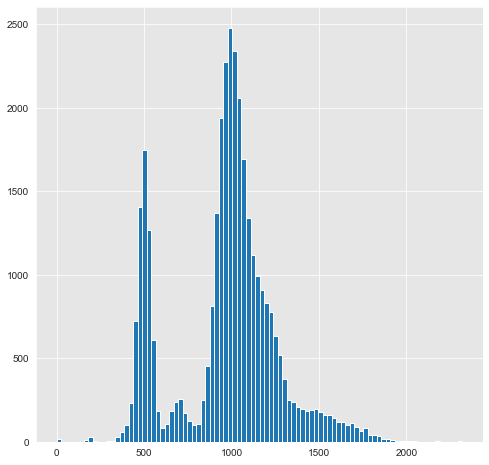

In [26]:
# Overall Revenues Daily Avg considering all persons
hotel['Additional Expenditures by day'] = hotel['Additional Expenditures'] / hotel['Nights']
plt.figure(figsize=(8, 8))
hotel['Additional Expenditures by day'].hist(bins=90)

In [27]:
hotel['ADR Adjusted'] = hotel['ADR'] + hotel['Additional Expenditures by day'] 

In [28]:
# Check that we have valuable data
# 0s
zero_values = hotel.loc[(hotel['Adults']==0)&(hotel['Children']==0)&(hotel['Babies']==0)&(hotel['Nights']!=0)]
zero_values

IsCanceled  LeadTime  Adults  Children  Babies       Meal  \
52              0       125       0       0.0       0  SC          
3884            0         2       0       0.0       0  SC          
3964            0        44       0       0.0       0  SC          
9171            0        50       0       0.0       0  BB          
10349           0        55       0       0.0       0  SC          
10598           0         4       0       0.0       0  SC          
14735           0         9       0       0.0       0  SC          
16756           0       256       0       0.0       0  BB          
25006           0         1       0       0.0       0  SC          
37360           0        26       0       0.0       0  SC          
44153           0        57       0       0.0       0  SC          
49108           0        19       0       0.0       0  SC          
51635           0       122       0       0.0       0  SC          
51944           0       122       0       0.0       0  SC          
52968           0        33       0       0.0       0  SC          

                         Country Travelling Group Distribution Channel  \
52                       Denmark          Couples                TA/TO   
3884          Russian Federation          Couples                TA/TO   
3964                      Sweden          Couples                TA/TO   
9171   Iran, Islamic Republic of          Couples                TA/TO   
10349                    Denmark         Business            Corporate   
10598         Russian Federation          Couples                TA/TO   
14735                Netherlands           Groups                TA/TO   
16756                    Denmark          Couples                TA/TO   
25006                    Denmark          Couples                TA/TO   
37360             United Kingdom           Family                TA/TO   
44153                  Singapore          Couples               Direct   
49108              United States          Couples                TA/TO   
51635                    Denmark          Couples                TA/TO   
51944                Switzerland          Couples                TA/TO   
52968                    Denmark          Couples                TA/TO   

       Is Repeated Guest  Previous Cancellation  \
52                     0                      0   
3884                   0                      0   
3964                   0                      0   
9171                   0                      0   
10349                  1                      1   
10598                  0                      0   
14735                  0                      0   
16756                  0                      0   
25006                  0                      0   
37360                  0                      0   
44153                  0                      0   
49108                  0                      0   
51635                  0                      0   
51944                  0                      0   
52968                  0                      0   

       Previous Bookings Not Cancelled Reserved Room Type Assigned Room Type  \
52                                   0   D                  K                  
3884                                 0   A                  K                  
3964                                 0   A                  K                  
9171                                 0   A                  A                  
10349                                9   A                  K                  
10598                                0   A                  K                  
14735                                0   A                  K                  
16756                                0   A                  K                  
25006                                0   D                  K                  
37360                                0   D                  K                  
44153                               

In [29]:
## Missing Values. There are some 0s, hence we drop those
hotel = hotel.drop(zero_values.index, axis=0)
hotel.shape

(33917, 34)

In [30]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33917 entries, 0 to 59605
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   IsCanceled                       33917 non-null  int8   
 1   LeadTime                         33917 non-null  int32  
 2   Adults                           33917 non-null  int8   
 3   Children                         33917 non-null  float16
 4   Babies                           33917 non-null  int8   
 5   Meal                             33917 non-null  object 
 6   Country                          33917 non-null  object 
 7   Travelling Group                 33917 non-null  object 
 8   Distribution Channel             33917 non-null  object 
 9   Is Repeated Guest                33917 non-null  int8   
 10  Previous Cancellation            33917 non-null  int8   
 11  Previous Bookings Not Cancelled  33917 non-null  int8   
 12  Reserved Room Type

In [31]:
hotel.shape

(33917, 34)

**Histogram plot**

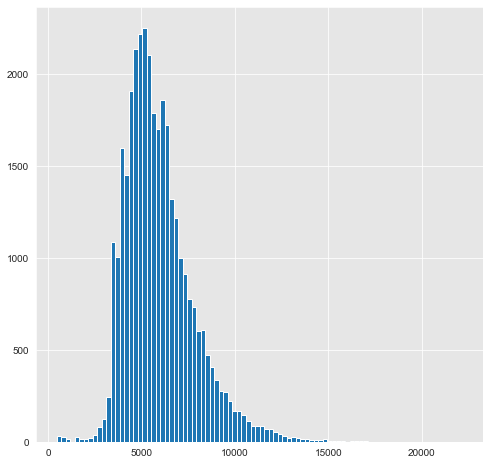

In [32]:
## Distribution
plt.figure(figsize=(8, 8))
hotel['ADR Adjusted'].hist(bins=90)

*Observation*: The histogram graph doesn't show exactly a bell shape characteristic of a Gaussian distribution, rather a positively skewed distribution.

-----

An alternative to make it more normal-like could be to transform `ADR Adjusted` with the Box-Cox transformation, as follows. It is shown just for covering its possibility, but I will continue to consider only the variable not-Box-Cox-transformed for my model.

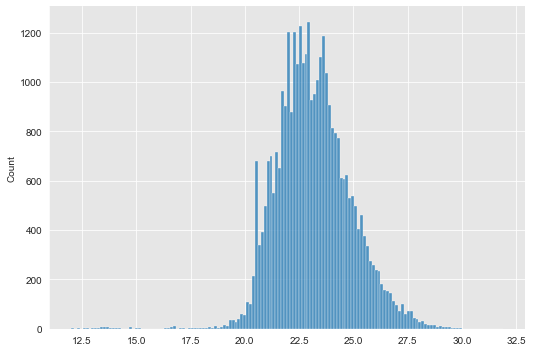

In [33]:
fitted_data, fitted_lambda = boxcox(hotel['ADR Adjusted']) 
sns.displot(fitted_data, aspect=1.5)

**Q-Q plot**

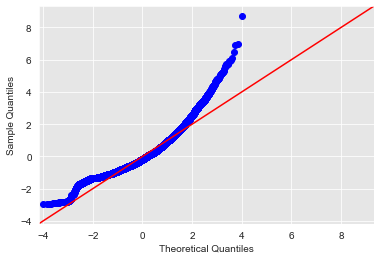

In [34]:
qq_adr = sm.qqplot(hotel['ADR Adjusted'], fit=True, line='45')

*Observation*: The blue dots deviated from the red line show a deviation from the expected normal distribution. Since they are quite a few, I can confidently say `ADR Adjusted` is not normally distributed.


-----

<a id='S2.2'></a>
<h2>2.2 Multivariate Analyses <span class="tocSkip"></span></h2>

Bi-variate analysis finds out the relationship between two variables, that in this case are continuous.

Correlation plots and metrics can help find out if two features are strongly correlated or if they offer the same information. Finding the two variables not correlated makes the results of my approach more robust. In fact, correlation coefficient can also be used as the similarity measurement for reducing features [[3]](#R3) <a id="r3"></a>.

I will look at distribution and relationship to validate, or not, the Pearson correlation coefficient assumptions.

<h3>2.2.2 Scatterplot and KDE <span class="tocSkip"></span></h3>

Scatterplots are useful in having a visual understanding of the relationships between two variables and for looking at potential outliers.

The following is a function that makes easier for me to customize the plots by tweaking only few parameters.

In [35]:
def scatter_matrix_all(df, *vars, style="ticks", diag_kind="kde", kind='reg', hue=None, height=5, 
                       plot_kws={'scatter_kws': {'alpha': 0.1, 's': 3}}):
    
    count_vars = 0
    for col in vars:
        count_vars += 1
    
    if count_vars>0:
        matrix_0 = sns.pairplot(df, vars=vars, diag_kind=diag_kind, kind=kind, hue=hue, height=height,
                               plot_kws=plot_kws)
        return matrix_0
        
    else:
        var = []
        vars = []
        
        for feat in df.columns:
            if type(df[feat][1])!=str:
                vars.append(feat)
            else:
                pass

        if len(vars) < 5:
            matrix_0 = sns.pairplot(df, vars=vars, diag_kind=diag_kind, 
                          kind=kind, hue=hue,
                          height=height
                         )
        
        elif len(vars) < 10:
            var_0 = vars[0:5]
            var_1 = vars[5:10]
            matrix_0 = sns.pairplot(df, vars=vars, diag_kind=diag_kind, kind=kind, hue=hue, height=height)
            matrix_1 = sns.pairplot(df, vars=var_1, diag_kind=diag_kind, kind=kind, hue=hue, height=height)
            return matrix_0, matrix_1
        
        elif len(vars) > 15:
            var_0 = vars[0:5]
            var_1 = vars[5:10]
            var_2 = vars[10:15]
            matrix_0 = sns.pairplot(df, vars=vars, diag_kind=diag_kind, kind=kind, hue=hue, height=height)
            matrix_1 = sns.pairplot(df, vars=var_1, diag_kind=diag_kind, kind=kind, hue=hue, height=height)
            matrix_2 = sns.pairplot(df, vars=var_2, diag_kind=diag_kind, kind=kind, hue=hue, height=height)
            print('***Warning: Only the first 15 variables have been modelled***')
            return matrix_0, matrix_1, matrix_2
            
    
    sns.set(style=style, color_codes=True)
        
    return "Done"

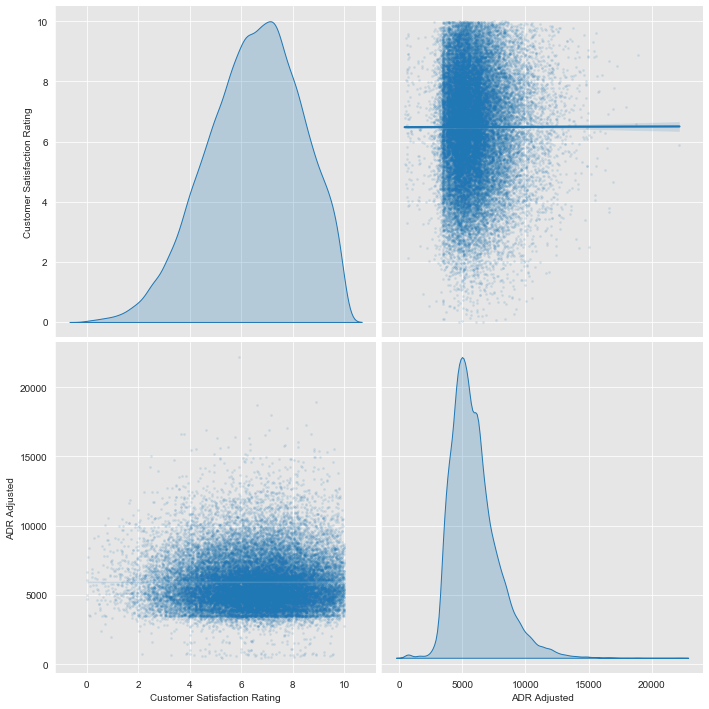

In [36]:
scatter_matrix_all(hotel, 'Customer Satisfaction Rating', 'ADR Adjusted',  
                   plot_kws={'scatter_kws': {'alpha': 0.1, 's': 3}}
                 )

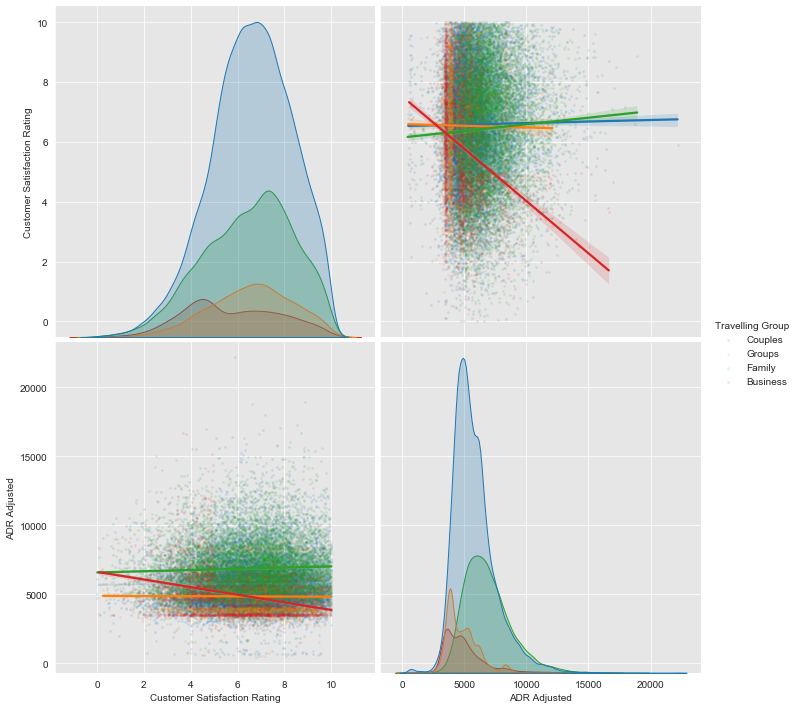

In [37]:
scatter_matrix_all(hotel, 'Customer Satisfaction Rating', 'ADR Adjusted', hue='Travelling Group')

**Kernel-density estimate using Gaussian kernels**

2D kernel pdf graphics may   help   the   user   in differentiating  the  sample  into  subsample, as better alternative to 2D histograms. Such  graphics  are informative when a sample contains many identical data, which are not visible in an x-y plot [[4]](#R4)<a id="r4"></a>.

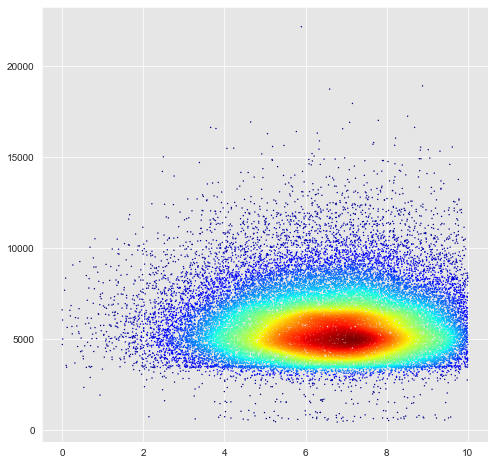

In [38]:
# Stack arrays in sequence vertically (row wise, equivalent to concatenation along the first axis)
xy = np.vstack([hotel['ADR Adjusted'], hotel['Customer Satisfaction Rating']])

# Representation of a kernel-density estimate using Gaussian kernels, PDF of a random variable 
# in a non-parametric way since neither of the two vars are normally ditributed
z = gaussian_kde(xy)(xy)

fig = plt.figure(figsize=(8, 8))
plt.scatter(hotel['Customer Satisfaction Rating'],
            hotel['ADR Adjusted'],
            c=z,
            edgecolor='',
            s=2,
            cmap='jet'
           )

*Observation*: there is a large concentration in the red area, the further it is from there the sparser are the data points.


----

<h3>2.2.1 Correlation <span class="tocSkip"></span></h3>

Two assumptions of the Pearson correlation coefficient are violated, namely they are not normally distributed, and there is no linear relationship between the two variables as shown in the scatter plot above.


----

<a id='S2.3'></a>
<h2>2.3 Outliers <span class="tocSkip"></span></h2>

Keeping outliers in the dataset may turn out in the model overfitting, while removing all the outliers may result in underfit models.

Outliers can be due to:

- Measurement/input error
- Data corruption
- True outlier observation far from the center of mass of observations
    
    
There are several ways, "rules of thumb", to proceed in order to detect and possibly remove outliers. Those I will take into consideration are:
- simple univariate statistics
    - Standard deviation method
    - Interquartile Range (IQR) method, called Tukey's rule with *k* = 1.5
- outlier detection model (multivariate)
    - Isolation Forest

The *standard deviation method* is quite common by setting the threshold at 3 std. Since it assumes that the distribution is normal, but those I am studying are not, I exclude this method.

Firstly, I will start by looking at the distribution of the two features via boxplot and by further investigating extreme values, to see if there is any evident underlying cause of concern. Secondly, I will identify the outliers with the IQR method. Thirdly, I will proceed with the Isolation Forest methodology by setting the `contamination` parameter for finding a comparable quantity of outliers. Lastly, I will define outliers those values identified via the univariate method that are also confirmed by the multivariate approach.


----

<h3>2.3.1 Tukey's rule <span class="tocSkip"></span></h3>

IQR is an appropriate statistic for summarizing a non-Gaussian distribution sample of data.
The IQR is calculated as the difference between the 75th and the 25th percentiles of the data (i.e. the box in the box-and-whisker plot). 
The IQR can be used to identify outliers beyond the two thresholds on the sample values that are a factor *k* of the IQR below the 25th percentile and above the 75th percentile. A common approach is to use the Tukey's rule and to set the *k* factor to 1.5, but *k* equal to 3 can also be used for considering only extreme outliers.

**Customer Satisfaction Rating**

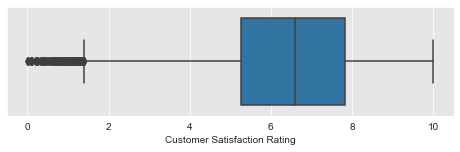

In [39]:
plt.figure(figsize=(8, 2))
sns.boxplot(x=hotel['Customer Satisfaction Rating'])

In [40]:
# Extreme outliers
out_ratings = hotel.loc[hotel['Customer Satisfaction Rating']<0.5]
md("IQR method identifies {} outliers in `Customer Satisfaction Rating`.".format(len(out_ratings)))

IQR method identifies 27 outliers in `Customer Satisfaction Rating`.

In [41]:
out_ratings

IsCanceled  LeadTime  Adults  Children  Babies       Meal  \
5245            0        10       2       1.0       0  SC          
5422            0       161       2       0.0       0  BB          
5499            0        91       2       1.0       0  BB          
5908            0       104       2       0.0       0  BB          
13180           0        53       1       0.0       0  BB          
16501           0       151       2       0.0       0  BB          
19185           0       213       1       0.0       0  HB          
21178           0        58       2       1.0       0  SC          
21510           0        56       1       0.0       0  BB          
22099           0         0       2       1.0       0  SC          
22668           0        58       2       0.0       0  BB          
23815           0        11       2       0.0       0  BB          
23940           0       346       2       0.0       0  HB          
24110           0        48       2       0.0       0  BB          
29243           0         0       1       0.0       0  BB          
30776           0        61       2       1.0       0  BB          
34270           0         1       2       1.0       0  SC          
35900           0        84       2       0.0       0  BB          
37914           0       304       2       1.0       0  BB          
38849           0       265       2       0.0       0  HB          
39476           0        97       2       0.0       0  HB          
40747           0       118       2       0.0       0  BB          
45881           0         0       2       0.0       0  BB          
48201           0        44       1       0.0       0  BB          
50199           0       168       3       1.0       0  BB          
52536           0        12       1       0.0       0  BB          
58399           0        21       2       1.0       0  BB          

                  Country Travelling Group Distribution Channel  \
5245       United Kingdom           Family                TA/TO   
5422               Israel          Couples               Direct   
5499              Denmark           Family                TA/TO   
5908                Italy           Family                TA/TO   
13180             Denmark          Couples                TA/TO   
16501             Denmark           Groups                TA/TO   
19185             Denmark           Groups                TA/TO   
21178  Russian Federation           Family                TA/TO   
21510              Sweden           Family                TA/TO   
22099              France           Family               Direct   
22668              France          Couples               Direct   
23815             Denmark           Family                TA/TO   
23940             Germany          Couples                TA/TO   
24110              France          Couples                TA/TO   
29243             Denmark         Business            Corporate   
30776              France           Family                TA/TO   
34270       United States           Family                TA/TO   
35900              Norway          Couples                TA/TO   
37914              France           Family                TA/TO   
38849             Germany          Couples                TA/TO   
39476      United Kingdom          Couples                TA/TO   
40747               Italy          Couples                TA/TO   
45881             Denmark          Couples                TA/TO   
48201              France          Couples                TA/TO   
50199              Brazil           Family                TA/TO   
52536             Denmark         Business            Corporate   
58399              France           Family                TA/TO   

       Is Repeated Guest  Previous Cancellation  \
5245                   0                      0   
5422                   0                      0   
5499                   0                      0   
5908                 

In [42]:
# Calculate 1st and 3rd quartile
q1_rating = hotel['Customer Satisfaction Rating'].quantile(0.25)
q3_rating = hotel['Customer Satisfaction Rating'].quantile(0.75)

# Interquartile range
iqr_rating = q3_rating - q1_rating
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q1_rating, q3_rating, iqr_rating))

# calculate the outlier cutoff
cutoff_rating = iqr_rating * 1.5
lower_rating, upper_rating = q1_rating - cutoff_rating, q3_rating + cutoff_rating

# identify outliers
low_outliers_rating = hotel.loc[(hotel['Customer Satisfaction Rating'] < lower_rating)]
up_outliers_rating = hotel.loc[(hotel['Customer Satisfaction Rating'] > upper_rating)]
outliers_rating = pd.concat([low_outliers_rating, up_outliers_rating])
outliers_rating['anomaly'] = 0

print("Identified lower outliers in 'Customer Satisfaction Rating': %d" % len(low_outliers_rating))
print("Identified upper outliers in 'Customer Satisfaction Rating': %d" % len(up_outliers_rating))

Percentiles: 25th=5.258, 75th=7.828, IQR=2.570
Identified lower outliers in 'Customer Satisfaction Rating': 143
Identified upper outliers in 'Customer Satisfaction Rating': 0


**ADR Adjusted**

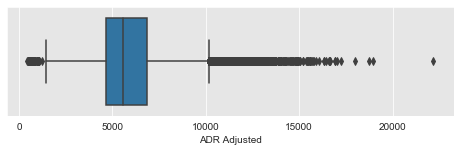

In [43]:
plt.figure(figsize=(8, 2))
sns.boxplot(x=hotel['ADR Adjusted'])

In [44]:
out_adr = hotel.loc[hotel['ADR Adjusted']>17000]
md("There are {} values beyond 17000 in `ADR Adjusted`.".format(len(out_adr)))

There are 6 values beyond 17000 in `ADR Adjusted`.

In [45]:
out_adr

IsCanceled  LeadTime  Adults  Children  Babies       Meal      Country  \
7152            0       173       2       1.0       0  HB              France   
15541           0        14       3       1.0       0  HB               Spain   
57418           0        35       3       1.0       0  BB         Switzerland   
58894           0        43       2       1.0       0  HB             Belgium   
59313           0        21       3       1.0       0  BB              France   
59410           0        81       2       2.0       0  BB             Denmark   

      Travelling Group Distribution Channel  Is Repeated Guest  \
7152           Couples                TA/TO                  0   
15541           Family               Direct                  0   
57418           Family               Direct                  0   
58894           Family                TA/TO                  0   
59313           Family                TA/TO                  0   
59410          Couples               Direct                  0   

       Previous Cancellation  Previous Bookings Not Cancelled  \
7152                       0                                0   
15541                      0                                0   
57418                      0                                0   
58894                      0                                0   
59313                      0                                0   
59410                      0                                0   

      Reserved Room Type Assigned Room Type  Booking Changes     Deposit Type  \
7152    A                  D                               0  No Deposit        
15541   G                  G                               1  No Deposit        
57418   G                  G                               1  No Deposit        
58894   F                  F                               0  No Deposit        
59313   D                  D                               0  No Deposit        
59410   E                  E                               1  No Deposit        

             Agent      Company    Customer Type  Required Car Parking Spaces  \
7152            28         NULL  Transient-Party                            0   
15541           14         NULL        Transient                            0   
57418           14         NULL        Transient                            0   
58894            9         NULL        Transient                            0   
59313            9         NULL        Transient                            0   
59410         NULL         NULL  Transient-Party                            0   

       # Special Requests Reservation Status  Age  Nights       ADR  Bar  \
7152                    1          Check-Out   28       3  16790.00  447   
15541                   1          Check-Out   39       3  17127.18  943   
57418                   0          Check-Out   40       3  15410.00  833   
58894                   1          Check-Out   40       3  16082.98  675   
59313                   0          Check-Out   40       2  17273.00  814   
59410                   4          Check-Out   28       2  20769.00  556   

       Restaurant  Breakfast  Other  Additional Expenditures Arrival Date  \
7152       2515.0      512.0   42.0                   3516.0   2016-07-25   
15541      3328.0      528.0   73.0                   4872.0   2016-08-18   
57418      3419.0      536.0   82.0                   4870.0   2016-12-25   
58894      2243.0      554.0   58.0                   3530.0   2016-12-29   
59313      2098.0      313.0   79.0                   3304.0   2016-12-30   
59410      2045.0      157.0   64.0                   2822.0   2016-12-31   

       Customer Satisfaction Rating  Additional Expenditures by day  \
7152                       7.156250                     1172.000000   
15541                      6.593750                     1624.000000   
57418                      7.792969                     1623.333333   
58894                      

In [46]:
# Calculate 1st and 3rd quartile
q1_adr = hotel['ADR Adjusted'].quantile(0.25)
q3_adr = hotel['ADR Adjusted'].quantile(0.75)

# Interquartile range
iqr_adr = q3_adr - q1_adr
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q1_adr, q3_adr, iqr_adr))

# calculate the outlier cutoff
cutoff_adr = iqr_adr * 1.5
lower_adr, upper_adr = q1_adr - cutoff_adr, q3_adr + cutoff_adr

# identify outliers indexes
low_outliers_adr = hotel.loc[(hotel['ADR Adjusted'] < lower_adr)] 
up_outliers_adr = hotel.loc[(hotel['ADR Adjusted'] > upper_adr)]
outliers_adr = pd.concat([low_outliers_adr, up_outliers_adr])
outliers_adr['anomaly'] = 0

print("Identified lower outliers in 'ADR Adjusted': %d" % len(low_outliers_adr.index))
print("Identified upper outliers in 'ADR Adjusted': %d" % len(up_outliers_adr.index))

Percentiles: 25th=4646.800, 75th=6854.000, IQR=2207.200
Identified lower outliers in 'ADR Adjusted': 71
Identified upper outliers in 'ADR Adjusted': 1079


In [47]:
outliers_adr

IsCanceled  LeadTime  Adults  Children  Babies       Meal  Country  \
375             0        44       1       0.0       0  HB         Denmark   
526             0        44       1       0.0       0  HB         Denmark   
818             0        30       0       2.0       0  BB         Denmark   
976             0        20       1       0.0       0  BB          France   
1543            0        33       0       1.0       0  BB          Brazil   
...           ...       ...     ...       ...     ...        ...      ...   
59444           0       103       3       0.0       0  BB           Spain   
59478           0        38       2       1.0       0  BB         Belgium   
59512           0        29       3       0.0       0  BB           Italy   
59543           0        77       2       2.0       0  BB           Italy   
59580           0        17       2       1.0       0  BB         Denmark   

      Travelling Group Distribution Channel  Is Repeated Guest  \
375             Groups                TA/TO                  0   
526             Groups                TA/TO                  0   
818            Couples                TA/TO                  0   
976           Business            Corporate                  0   
1543            Family                TA/TO                  0   
...                ...                  ...                ...   
59444          Couples                TA/TO                  0   
59478           Family               Direct                  0   
59512          Couples                TA/TO                  0   
59543         Business                TA/TO                  0   
59580           Family                TA/TO                  0   

       Previous Cancellation  Previous Bookings Not Cancelled  \
375                        0                                0   
526                        0                                0   
818                        0                                0   
976                        0                                0   
1543                       0                                0   
...                      ...                              ...   
59444                      0                                0   
59478                      0                                0   
59512                      0                                0   
59543                      0                                0   
59580                      0                                0   

      Reserved Room Type Assigned Room Type  Booking Changes     Deposit Type  \
375     A                  A                               1  No Deposit        
526     A                  D                               1  No Deposit        
818     B                  B                               2  No Deposit        
976     E                  E                               1  No Deposit        
1543    B                  B                               0  No Deposit        
...                  ...                ...              ...              ...   
59444   A                  D                               0  No Deposit        
59478   E                  E                               0  No Deposit        
59512   D                  D                               0  No Deposit        
59543   F                  F                               2  No Deposit        
59580   F                  G                               1  No Deposit        

             Agent      Company    Customer Type  Required Car Parking Spaces  \
375              1         NULL  Transient-Party                            0   
526              1         NULL  Transient-Party                            0   
818              9         NULL  Transient-Party                            0   
976             91         NULL        Transient                            0   
1543             9         NULL  Transient-Party                            0   
...            ...          ...              ... 

In [48]:
md("IQR method identifies {} outliers in `ADR Adjusted`.".format(len(outliers_adr)))

IQR method identifies 1150 outliers in `ADR Adjusted`.

<h3>2.3.2 Multivariate: Isolation Forest <span class="tocSkip"></span></h3>

Isolation Forest is a tree-based anomaly detection algorithm. It models the data isolating anomalies that are both few in number and different in the feature space by what is defined as *normal*. It can be used in a wide range of fields (e.g. fraud, network intrusion, ..).

The most important and arbitrary parameter to be set is `contamination` (value between 0.0 - 0.5), that determines the amount of contamination of the data set, i.e. the proportion of outliers in the data set. It is used when fitting to define the threshold on the scores of the samples.

The scikit-learn library provides the basic implementation of the Isolation Forest method. An Extended version (EIF) resolves issues with assignment of anomaly score to given data points [[5]](#R5)<a id="r5"></a>, but as of end 2020 is not implemented in the popular module.

In [49]:
metrics_df = hotel[['Customer Satisfaction Rating', 'ADR Adjusted']]
to_model_columns = metrics_df.columns
clf = IsolationForest(n_estimators=200,
                      max_samples='auto',
                      contamination=float(.005),
                      max_features=2,
                      bootstrap=False,
                      n_jobs=-1,
                      random_state=42,
                      verbose=0)
clf.fit(hotel[to_model_columns])
pred = clf.predict(hotel[to_model_columns])
hotel['anomaly'] = pred

#Find the number of anomalies and normal points here points classified -1 are anomalous
print(hotel['anomaly'].value_counts())

 1    33747
-1      170
Name: anomaly, dtype: int64


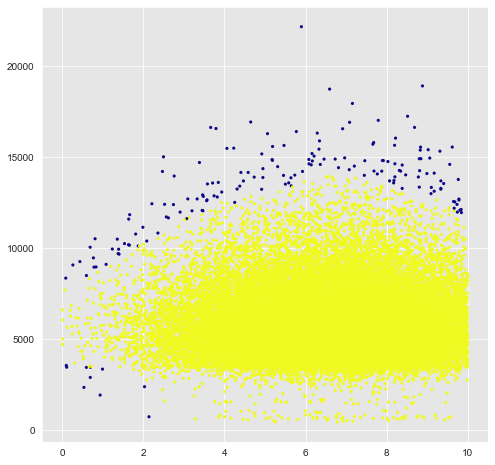

In [50]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(hotel['Customer Satisfaction Rating'],
            hotel['ADR Adjusted'],
            c=hotel['anomaly'],
            edgecolor='',
            s=10,
            cmap='plasma')

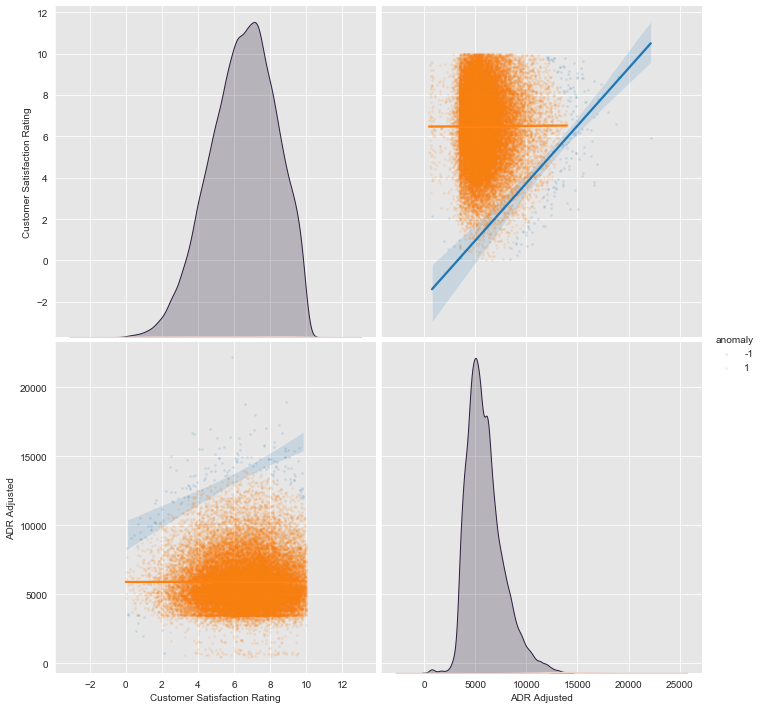

In [51]:
scatter_matrix_all(hotel, 'Customer Satisfaction Rating', 'ADR Adjusted', hue='anomaly')

In [52]:
## Final inner merge of outliers
outliers_iso_forest = hotel.loc[hotel['anomaly'] == -1]
outliers_iqr = pd.concat([outliers_rating, outliers_adr]) 
outliers = outliers_iqr.merge(outliers_iso_forest, how='inner',
                                     left_on=outliers_iqr.index, right_on=outliers_iso_forest.index
                                    )
outliers

key_0  IsCanceled_x  LeadTime_x  Adults_x  Children_x  Babies_x  \
0      481             0           4         1         0.0         0   
1     5727             0           1         1         0.0         0   
2     5769             0         132         3         0.0         0   
3     6213             0           1         2         0.0         0   
4     6570             0          62         2         1.0         0   
..     ...           ...         ...       ...         ...       ...   
164  58894             0          43         2         1.0         0   
165  59036             0           2         2         1.0         1   
166  59273             0          57         2         0.0         0   
167  59313             0          21         3         1.0         0   
168  59410             0          81         2         2.0         0   

        Meal_x Country_x Travelling Group_x Distribution Channel_x  \
0    BB          Denmark           Business              Corporate   
1    BB          Denmark           Business              Corporate   
2    BB           France            Couples                  TA/TO   
3    BB          Denmark            Couples                 Direct   
4    HB          Germany           Business                  TA/TO   
..         ...       ...                ...                    ...   
164  HB          Belgium             Family                  TA/TO   
165  HB          Denmark             Family                 Direct   
166  HB           France             Family                  TA/TO   
167  BB           France             Family                  TA/TO   
168  BB          Denmark            Couples                 Direct   

     Is Repeated Guest_x  Previous Cancellation_x  \
0                      1                        0   
1                      1                        0   
2                      0                        0   
3                      0                        0   
4                      0                        0   
..                   ...                      ...   
164                    0                        0   
165                    0                        0   
166                    0                        0   
167                    0                        0   
168                    0                        0   

     Previous Bookings Not Cancelled_x Reserved Room Type_x  \
0                                    7     A                  
1                                    3     D                  
2                                    0     D                  
3                                    0     E                  
4                                    0     A                  
..                                 ...                  ...   
164                                  0     F                  
165                                  0     E                  
166                                  0     D                  
167                                  0     D                  
168                                  0     E                  

    Assigned Room Type_x  Booking Changes_x   Deposit Type_x      Agent_x  \
0       A                                 0  No Deposit              NULL   
1       D                                 0  No Deposit              NULL   
2       D                                 0  No Deposit                 9   
3       E                                 0  No Deposit                14   
4       A                                 0  No Deposit                 9   
..                   ...                ...              ...          ...   
164     F                                 0  No Deposit                 9   
165     E                                 1  No Deposit              NULL   
166     D                                 0  No Deposit                 9   
167     D                                 0  No Deposit                 9   
168     E                                 1  No Deposit   

Prior to making the decision to remove them or not, I need to consider what else would need to be done to the data. Since I will apply a Spectral Clustering algorithm for unsupervised data, it would not heavily be impacted by the outliers [[6]](#R6)<a id="r6"></a>. On the other hand, few entries seem unreasonable different, and in the coming Notebooks I will apply regression algorithms for forecasting. Based on this, I made the decision to remove a limited amount of outliers that are identified both by the IQR method and the Isolation Forest algorithm, for having a more robust result in the second and third parts of the project.

In [70]:
hotel = hotel.drop(outliers.key_0, axis=0)
hotel.shape

KeyError: '[  481  5727  5769  6213  6570  7259  9887 11671 13180 13458 13458 17307\n 26140 28427 29176 29243 30776 50199 52235 52536 55379 55379 55768 58617\n  6821   661   736  1014  1362  1508  1805  1827  1943  2014  2055  2134\n  2816  3011  3138  3297  3315  3791  4313  4425  4516  5559  5574  5671\n  5809  6161  6448  6806  6941  7076  7152  8019  8297  8299  8315  9223\n  9303 10005 10325 10392 10597 11100 11219 11580 11777 11868 12242 12299\n 12854 13075 13171 13328 13725 13912 14019 14209 14232 14284 14293 14772\n 14943 14973 15152 15220 15260 15261 15288 15541 15810 15992 16006 16493\n 17354 18318 18384 18977 21048 22794 22902 25157 25971 26264 26525 26899\n 26950 27092 27645 29097 29706 29768 30252 31134 31243 31700 32273 32277\n 33812 33968 33973 36857 36944 37318 37320 37688 37710 38074 39421 39651\n 40211 41183 42548 43031 43947 44225 44515 44619 45095 46060 47158 47677\n 48561 48666 48899 48965 50931 51465 53433 53672 54340 55924 55960 56025\n 56308 56893 56977 57418 57573 57676 58149 58391 58894 59036 59273 59313\n 59410] not found in axis'

<a id='S2.4'></a>
<h2>2.4 Final Data Preprocessing <span class="tocSkip"></span></h2>

Two steps are needed before clustering the data points, namely scaling and a final memory optimization.

<h3>2.4.1 Scaling<span class="tocSkip"></span></h3>


Thus far, the two features have been adjusted, their outliers have been removed, and the missing/0/inf values have been properly treated. 

For distance-based algorithm, e.g. based on euclidean distances, scaling is important for comparing the features on the same scale when training the model. Since I am going to apply spectral clustering, and as we will see it is connectivity-based, scaling is not essential. Yet, it may help towards faster convergence. Hence, I am going to use the estimator `minmax_scale` from the scikit-learn library, for transforming the features by scaling each feature to the given range (i.e. 0-1): for each feature, each value is subtracted by the minimum value of the respective feature and then divided by the range of original maximum and minimum of the same feature. It doesn't change the distribution of the features.

An alternative not implemented here, is to use `RobustScaler` for having results robust to outliers. Yet, I am reasonably satisfied with the treatment of the outliers, hence `minmax_scale` is satisfactory.

In [54]:
hotel['ADR Adjusted - Scaled'] = minmax_scale(hotel['ADR Adjusted'])
hotel['Customer Satisfaction Rating - Scaled'] = minmax_scale(hotel['Customer Satisfaction Rating'])

In [55]:
hotel.head()

IsCanceled  LeadTime  Adults  Children  Babies       Meal         Country  \
0           0       148       2       0.0       0  BB                  Spain   
1           0       462       2       0.0       0  BB         United Kingdom   
3           0        39       2       0.0       0  SC                Denmark   
4           0         0       3       1.0       0  BB                Denmark   
6           0        82       2       0.0       0  BB                Belgium   

  Travelling Group Distribution Channel  Is Repeated Guest  \
0          Couples                TA/TO                  0   
1           Groups                TA/TO                  0   
3          Couples                TA/TO                  0   
4           Family               Direct                  0   
6          Couples                TA/TO                  0   

   Previous Cancellation  Previous Bookings Not Cancelled Reserved Room Type  \
0                      0                                0   A                  
1                      0                                0   A                  
3                      0                                0   A                  
4                      0                                0   A                  
6                      0                                0   A                  

  Assigned Room Type  Booking Changes     Deposit Type        Agent  \
0   A                               0  No Deposit                 9   
1   A                               0  No Deposit               229   
3   A                               0  No Deposit                 9   
4   E                               0  No Deposit              NULL   
6   A                               0  No Deposit                 9   

       Company    Customer Type  Required Car Parking Spaces  \
0         NULL  Transient-Party                            0   
1         NULL  Transient-Party                            0   
3         NULL        Transient                            0   
4         NULL        Transient                            0   
6         NULL        Transient                            0   

   # Special Requests Reservation Status  Age  Nights      ADR   Bar  \
0                   2          Check-Out   32       8  4525.94  2080   
1                   1          Check-Out   33       3  5182.82   812   
3                   1          Check-Out   77       1  4926.60   206   
4                   0          Check-Out   48       1  8556.00   315   
6                   1          Check-Out   60       6  5257.80  1215   

   Restaurant  Breakfast  Other  Additional Expenditures Arrival Date  \
0      6048.0      525.0   66.0                   8719.0   2016-07-01   
1      2096.0      304.0   53.0                   3265.0   2016-07-01   
3       688.0       88.0   48.0                   1030.0   2016-07-01   
4      1193.0      221.0   92.0                   1821.0   2016-07-01   
6      4306.0      189.0   25.0                   5735.0   2016-07-01   

   Customer Satisfaction Rating  Additional Expenditures by day  ADR Adjusted  \
0                      3.183594                     1089.875000   5615.815000   
1                      7.617188                     1088.333333   6271.153333   
3                      7.367188                     1030.000000   5956.600000   
4                      8.445312                     1821.000000  10377.000000   
6                      6.542969                      955.833333   6213.633333   

   anomaly  ADR Adjusted - Scaled  Customer Satisfaction Rating - Scaled  
0        1               0.382112                               0.318115  
1        1               0.430646                               0.761230  
3        1               0.407350                               0.735840  
4        1               0.734721                               0.843750  
6        1               0.426386                               0.653809

<h3>2.4.2 Memory Optimization <span class="tocSkip"></span></h3>

In [56]:
hotel = optimize_memory(hotel)
hotel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33750 entries, 0 to 59605
Data columns (total 37 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   IsCanceled                             33750 non-null  int8   
 1   LeadTime                               33750 non-null  int32  
 2   Adults                                 33750 non-null  int8   
 3   Children                               33750 non-null  int8   
 4   Babies                                 33750 non-null  int8   
 5   Meal                                   33750 non-null  object 
 6   Country                                33750 non-null  object 
 7   Travelling Group                       33750 non-null  object 
 8   Distribution Channel                   33750 non-null  object 
 9   Is Repeated Guest                      33750 non-null  int8   
 10  Previous Cancellation                  33750 non-null  int8   
 11  Pr

In [57]:
# Final checks
print(hotel.isin([np.inf]).sum())
print(hotel.isnull().sum())

IsCanceled                               0
LeadTime                                 0
Adults                                   0
Children                                 0
Babies                                   0
Meal                                     0
Country                                  0
Travelling Group                         0
Distribution Channel                     0
Is Repeated Guest                        0
Previous Cancellation                    0
Previous Bookings Not Cancelled          0
Reserved Room Type                       0
Assigned Room Type                       0
Booking Changes                          0
Deposit Type                             0
Agent                                    0
Company                                  0
Customer Type                            0
Required Car Parking Spaces              0
# Special Requests                       0
Reservation Status                       0
Age                                      0
Nights     

In [ ]:
# Freeing memory
del metrics_df, outliers, outliers_adr, outliers_iqr, outliers_iso_forest
del pred, up_outliers_adr, xy, z, fitted_data

<a id='S3'></a>
<h1>3. Spectral Clustering for Segmenting Customers <span class="tocSkip"></span></h1>

> "[..] some have said that there are as many cluster-analysis methods as there are people performing cluster analysis. This is a gross understatement! *There exist infinitely more ways to perform a cluster analysis than people who perform them*" [[7]](#R7)<a id="r7"></a>

A clustering method attempts to group objects based on the definition of similarity supplied to it, when no pre-defined categories/classes are available. Given that there are many algorithms available for clustering, an important note regards my choice of *spectral clustering* for solving this particular problem. 

**K-Means** 

I excluded the popular and basic K-means because it tends to determine clusters of comparable spatial extent and with regular circle-like shapes - which is not appropriate in this case.

**DBSCAN**

DBSCAN is a density-based spatial clustering that finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density. But as we have seen in the KDE, the data is clustered in one main group. Using such a method would likely find just one cluster, with noise sparse all around it - that would defy any attempt of segmenting the data.

**Spectral Clustering**

In this case, a connectivity-based clustering algorithm looks much more interesting because as we have seen, in this case there is only a main group and we cannot visually identify well separated clusters. In this case, “segmentation” accurately describes this process even more than “clustering” [[8]](#R8)<a id="r8"></a>.



------



<a id='S3.1'></a>
<h2>3.1 Spectral Clustering from Scratch <span class="tocSkip"></span></h2>

Below I present the main steps of the spectral clustering algorithm (up to a finite level of detail), and then build it from scratch.

**At-hand definitions**

| Element | Brief Definition
| ----- | ---------- 
| **Affinity (similarity) matrix** | It is a square matrix used to represent a finite graph, whose elements indicate how similar pairs of vertices are to each other (0 if dissimilar, 1 if identical). The affinity acts like the weights for the edges on the graph.
| **Adjacency matrix** | It is a square matrix used to represent a finite graph, whose elements indicate whether pairs of vertices are adjacent or not in the graph
| **Adjacency graph** | Graph that can be built from the adjacency matrix. E.g. if there’s a 1 in the cell of the adjacency matrix then an edge between the nodes of the column and row is drawn.
| **K-NN graph** | The k-nearest neighbor graph (k-NNG) is a graph in which two vertices p and q are connected by an edge, if the distance between p and q is among the k-th smallest distances from p to other objects from the original vertex set. k is a parameter, in the following example it is equal to 10 [[9]](#R9)<a id="r9"></a>.
| **Degree matrix** | It is a diagonal matrix which contains information about the degree of each vertex — i.e. the number of edges attached to each vertex
| **Graph Laplacian matrix** | There exist several variants, spectral graph theory studies them. The basic unnormalized graph Laplacian is calculated by subtracting the adjacency matrix from the degree matrix. Pivotal property of Laplacian matrix is: "If the adjacency graph (W) has K connected components, then L has K eigenvectors with an eigenvalue of 0."
| **Spectrum of eigenvalues** | The spectrum of a matrix is the set of its eigenvalues. Hence, "spectral" clustering.


-----



**Steps**

1. Construct the similarity matrix *S*, in which the values are the euclidean distances between each pair of points.


2. Determine the adjacency matrix *W* starting from the similarity matrix. It can be built in several ways, as described in the seminal paper by Ulrike von Luxburg (2007) [[10]](#R10)<a id="r10"></a>. Common methods are: 
    - *(a)* the *ε-neighborhood graph*. All points whose pairwise distances are smaller than ε are connected. By setting a threshold such that if the distance is within the predefined limit, the value in the *W* is set to 1 and 0 otherwise. 
    - *(b)* the *fully connected graph*. All points with positive similarity are connected with each other and all edges are weighted by s<sub>i,j</sub>. An example for such a similarity function is the Gaussian similarity function (Radial Basis Function kernel [[11]](#R11)<a id="r11"></a>):
    
    $$ s(x_i, x_j ) = exp \bigg( \frac{ - \lVert{x_i − x_j} \rVert ^2}{2σ^2} \bigg)  $$
    
    - *(c)* the *k-nearest neighbor graph* (*k-NN)*. A *directed graph* is done by connecting vertex v<sub>i</sub> with vertex v<sub>j</sub> if v<sub>j</sub> is among the k-nearest neighbors of v<sub>i</sub>. In order to make it into *undirected graph*, there are two ways:
        - *mutual k-nearest neighbor graph*: connect vertices v<sub>i</sub> and v<sub>j</sub> if both v<sub>i</sub> is among the k-nearest neighbors of v<sub>j</sub> and v<sub>j</sub> is among the k-nearest neighbors of v<sub>i</sub>
        - what is normally called *k-nearest neighbor graph*: connect vertex undirected edge if v<sub>i</sub> is among the k-nearest neighbors of v<sub>j</sub> *or* if v<sub>j</sub> is among the k-nearest neighbors of v<sub>i</sub>
        


3. Determine the degree matrix *D* by filling the cells along the diagonal by summing all the elements of the corresponding row in the adjacency matrix


4. Determine the Laplacian matrix *L*. There exist many Laplacian matrices used (see Ulrike von Luxburg, 2007 [[10]](#R10)<a id="r10"></a>).
    - Unnormalized. This is the formula used to show spectral clustering from scratch:  
    $$L = D - W$$  
    
    - Normalized, as the Laplacian matrix of the scikit-learn library. The most common in the literature are: 
        - the *symmetric matrix*:
        $$ L_{sym} := D ^{−1/2} LD ^{−1/2} = I −D ^{−1/2} WD ^{−1/2} $$
        
        - the *random walk matrix*:
        $$ L_{rw} := D ^{−1} L = I −D ^{−1} W $$


5. Compute the first *K* eigenvectors u<sub>1</sub>, . . . , u<sub>k</sub> of *L*. *K* is arbitrarily chosen and it will determine the number of constructed clusters. Yet an eigengap (also called spectral gap) heuristic can be applied [[10]](#R10)<a id="r10"></a>. The rule is to choose the number k such that all eigenvalues λ<sub>1</sub>,..,λ<sub>k</sub> are very small (close to zero) and then λ<sub>k+1</sub> is much larger. In other words, the number of clusters to pick corresponds to the number of eigenvalues that are very small before there is a large ___gap___ in the next eigenvalue - number of clusters that maximises the gap between consecutive eigenvalues. One justification is based on perturbation theory, where we observe that in the ideal case of k completely disconnected clusters,the eigenvalue 0 has multiplicity k, and then there is a gap to the (k + 1)<sup>th</sup> eigenvalue λ<sub>k+1</sub> > 0. For example, having seven eigenvalues before the gap indicates that there are likely seven clusters. There exist interesting alternatives with no need of specifying the number of clusters, e.g. see Lucińska & Wierzchoń (2017) [[12]](#R12)<a id="r12"></a>.

 
6. Train a k-means model on the *K* eigenvectors of the Laplacian matrix *L* and use it to classify the data:
    - Let U ∈ R<sup>n*k</sup> be the matrix containing the vectors u<sub>1</sub>, . . . , u<sub>k</sub> as columns
    - For i = 1, . . .,n, let y<sub>i</sub> ∈ R<sup>k</sup> be the vector corresponding to the i-th row of U.
    - Cluster the points (y<sub>i</sub>)<sub>i=1,...,n</sub> in R<sup>k</sup> with the *k-means* algorithm into clusters C<sub>1</sub>, . . . , C<sub>k</sub>. *The K-means steps are*:
        - initialize K random cluster centres
        - assign each data point to the closest cluster centre
        - set the new centre of the cluster as the mean of that cluster
        - repeat:
            - assign each data point to the closest cluster center
            - set the new centre
        - once there is no more change, that's done: calculate the variation of each cluster
        - repeat for X times and select those with lowest variation

The data points result being labeled. Below, step by step code numbered according to the steps just described.

NOTE: if by running the next cell the output is a convergence error `LinAlgError: Eigenvalues did not converge`, please re-run the cell for getting the outcome.

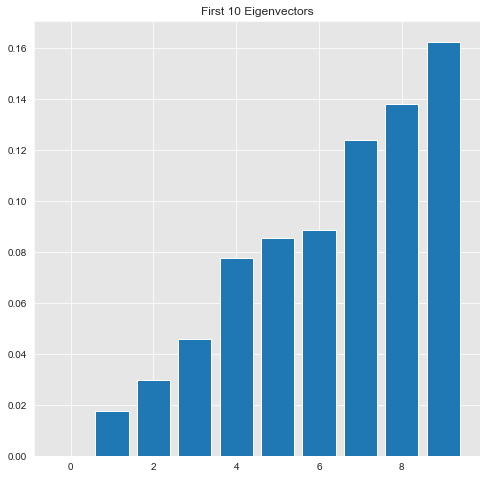

In [59]:
# Additional imports for spectral clustering from scratch
from scipy.spatial.distance import pdist, squareform

# Sample is reduced because this algorithm is much less efficient than the one in the scikit-learn library. Big O is too big
hotel_scratch = hotel.sample(n=3000, random_state=42)
X = hotel_scratch[['Customer Satisfaction Rating - Scaled',
                   'ADR Adjusted - Scaled']].to_numpy()

# 1. Similarity graph with euclidean distances within 0-1 values
d = squareform(pdist(X, 'sqeuclidean'))  # This is the similarity matrix with euclidean distances
sigma = 0.2
S = np.exp(-d / sigma)
del d

# 2. Determine the Adjacency matrix
n_neighbors = 10
W = np.zeros(S.shape)
for i in range(W.shape[0]):
    s = np.sort(S[i])
    W[i][S[i] >= s[-n_neighbors - 1]] = 1
W = np.fmax(W, W.T)
W = W - np.eye(W.shape[0])

# 3. Determine the Degree matrix
D = np.diag(np.sum(W, axis=0))

# 4. Determine the graph laplacian from the K-NN graph
L = D - W
del D, W, S, s

# 5. Compute the first k eigenvectors u1, . . . , uk of L
[vals, vecs] = np.linalg.eig(L)
del L
sorted_inds = np.argsort(vals.real, axis=0)
vecs = vecs[:, np.argsort(vals)]

# 6. Train a k-means model on the first K eigenvectors of the Laplacian matrix L
K = 4  # K is number of eigenvectors, hence number of clusters
vecs = vecs.real
clf = KMeans(n_clusters=K, init='k-means++')
clf.fit(vecs[:, sorted_inds[0:K]])
y_pred = clf.predict(vecs[:, sorted_inds[0:K]])

# Visualization. Barplot showing the real eig_vals, sorted
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_title('First 10 Eigenvectors')
barplot_eigenvectors = ax.bar(range(10), vals.real[sorted_inds[0:10]])#

del vecs, vals

plt.show()

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
scatter_hotel2 = ax.scatter(hotel_scratch['Customer Satisfaction Rating - Scaled'], 
                            hotel_scratch['ADR Adjusted - Scaled'],
                            c=y_pred, 
                            s=9)

plt.show()

del hotel_scratch, clf, sorted_inds

<a id='S3.2'></a>
<h2>3.2 Spectral Clustering based on k-NN graph for segmenting customers <span class="tocSkip"></span></h2>

At this stage, the features have been properly preprocessed and the customers are ready to be clustered into segments.

In [60]:
#2D spectral clustering
X = hotel[['Customer Satisfaction Rating - Scaled','ADR Adjusted - Scaled']].to_numpy()
spectral_2d = SpectralClustering(n_clusters=7, 
                                 assign_labels="discretize", 
                                 affinity='nearest_neighbors',
                                 n_neighbors=10,
                                 random_state=0, 
                                 n_init=15).fit(X)

In [61]:
hotel['Cluster'] = spectral_2d.labels_

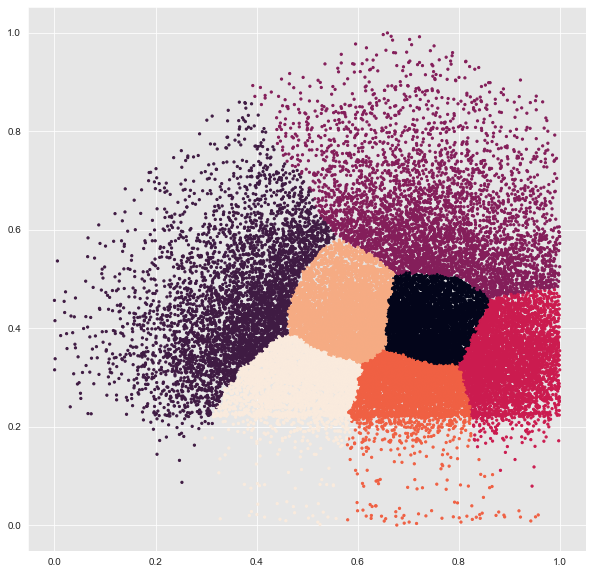

In [63]:
# Graphical representation
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
scatter_hotel2 = ax.scatter(hotel['Customer Satisfaction Rating - Scaled'], 
                            hotel['ADR Adjusted - Scaled'],
                            c=hotel['Cluster'], 
                            s=5)

<sub>Please note the neat demarcation among clusters. Applying fuzzy logic for clustering will be an interesting improvement to consider.<sub/>

In [64]:
## Creation of the DataFrame
hotel_sc = hotel.copy()
hotel_sc.reset_index(inplace=True)

# Freeing memory
del hotel

In [65]:
hotel_sc.tail()

index  IsCanceled  LeadTime  Adults  Children  Babies       Meal  \
33745  59599           0        55       1         0       0  BB          
33746  59601           0        54       1         0       0  BB          
33747  59602           0         0       2         1       0  BB          
33748  59603           0        43       2         0       0  BB          
33749  59605           0       103       2         0       0  BB          

           Country Travelling Group Distribution Channel  Is Repeated Guest  \
33745       France          Couples                TA/TO                  0   
33746       France          Couples                TA/TO                  0   
33747  Switzerland           Family               Direct                  1   
33748       France          Couples                TA/TO                  0   
33749       France          Couples                TA/TO                  0   

       Previous Cancellation  Previous Bookings Not Cancelled  \
33745                      0                                0   
33746                      0                                0   
33747                      0                                0   
33748                      0                                0   
33749                      0                                0   

      Reserved Room Type Assigned Room Type  Booking Changes     Deposit Type  \
33745   A                  A                               0  No Deposit        
33746   A                  A                               0  No Deposit        
33747   D                  D                               2  No Deposit        
33748   A                  A                               0  No Deposit        
33749   A                  A                               0  No Deposit        

             Agent      Company Customer Type  Required Car Parking Spaces  \
33745          104         NULL     Transient                            0   
33746          104         NULL     Transient                            0   
33747         NULL         NULL     Transient                            0   
33748          104         NULL     Transient                            0   
33749           28         NULL     Transient                            0   

       # Special Requests Reservation Status  Age  Nights          ADR  Bar  \
33745                   0          Check-Out   34       3  2882.820068  247   
33746                   0          Check-Out   22       3  2882.820068  316   
33747                   0          Check-Out   39       2  5520.000000  394   
33748                   0          Check-Out   43       3  5428.000000  646   
33749                   0          Check-Out   53       4  5750.000000  683   

       Restaurant  Breakfast  Other  Additional Expenditures Arrival Date  \
33745         929        133     22                     1331   2016-12-31   
33746        1035         73     21                     1445   2016-12-31   
33747        1864        273     49                     2580   2016-12-31   
33748        2027        154     44                     2871   2016-12-31   
33749        2374        376     49                     3482   2016-12-31   

       Customer Satisfaction Rating  Additional Expenditures by day  \
33745                      7.601562                      443.666656   
33746                      4.835938                      481.666656   
33747                      7.257812                     1290.000000   
33748                      7.007812                      957.000000   
33749                      7.113281                      870.500000   

       ADR Adjusted  anomaly  ADR Adjusted - Scaled  \
33745   3326.486572        1               0.212524   
33746   3364.486572        1               0.215332   
33747   6810.000000        1               0.470459   
33748   6385.000000        1               0.438965   
33749   6620.500000        1               0.456543   

       Customer Satisfaction Rating - 

<a id='S4'></a>
<h1>4. Clusters Interpretation <span class="tocSkip"></span></h1>


In the previous sections, the seven clusters have been determined via two features, what can be called *active input variables* [[13]](#R13)<a id="r13"></a> and will be the backbone of this initial interpretation.

The remaining variables are called *illustrative input variables*, which will be the focused of an advanced interpretation in the next Notebook, part 2.

Since the active input variables have participated in the creation of the clusters, they are not meaningful for statistically testing the significance of their differences. Rather, their mean is the statistic that I will use for labeling the clusters in a significant manner from a business perspective.

In [66]:
## Statistics of the two features on the whole dataset
hotel_sc[['ADR Adjusted', 'Customer Satisfaction Rating']].astype('float').describe()

ADR Adjusted  Customer Satisfaction Rating
count  33750.000000                  33750.000000
mean    5906.790599                      6.491229
std     1781.550979                      1.802528
min      456.250000                      0.003017
25%     4643.775146                      5.265625
50%     5580.000000                      6.601562
75%     6833.575073                      7.828125
max    13959.000000                     10.000000

In naming the clusters, both `ADR Adjusted` and `Customer Satisfaction Rating` per each cluster are defined as `low`, `medium` or `high`, depending on how the mean of the features of each cluster ranks relative to the other clusters. There are seven clusters, the two highest are called `high`, the two in the middle are called `middle`, the remaining three at the bottom are called `low`.

In [67]:
## Function that provides the description of the cluster according the above instructions, by the mean

def description_clusters_mean(df):
    mean_interpret = df[['ADR Adjusted', 'Customer Satisfaction Rating']].groupby(df['Cluster']).mean()
    mean_interpret['N° Clients'] = df['Customer Type'].groupby(df['Cluster']).count()

    # Clusters' means ADR Adjusted
    mean_interpret_adr = mean_interpret.sort_values(by=['ADR Adjusted'], ascending=False)
    mean_interpret_adr.reset_index(inplace=True)  # Double resetting index because I need the order of the clusters more than once
    mean_interpret_adr.reset_index(inplace=True)
    mean_interpret_adr.rename(columns={"index": "order_ADR"}, inplace=True)

    # Clusters' means Customer Satisfaction Rating
    mean_interpret = mean_interpret_adr.sort_values(by=['Customer Satisfaction Rating'], ascending=False).copy()
    mean_interpret.reset_index(inplace=True)
    mean_interpret.reset_index(inplace=True)
    mean_interpret.rename(columns={"level_0": "order_satisfaction"}, inplace=True)

    adr = []
    satisfaction = []
        
    for i in mean_interpret['order_ADR']:
        if (i>=0) & (i<2):
            adr.append('High Revenue')
        elif (i>=2) & (i<4):
            adr.append('Medium Revenue')
        elif (i>=4) & (i<=6):
            adr.append('Low Revenue')
    
    for i in mean_interpret['order_satisfaction']:
        if (i>=0) & (i<2):
            satisfaction.append('High Satisfaction')
        elif (i>=2) & (i<4):
            satisfaction.append('Medium Satisfaction')
        elif (i>=4) & (i<=6):
            satisfaction.append('Low Satisfaction')
    
    mean_interpret['adr'] = adr
    mean_interpret['satisfaction'] = satisfaction
    mean_interpret['Description'] = mean_interpret['adr'] + ' - ' + mean_interpret['satisfaction']
    mean_interpret.drop(columns=['adr', 'satisfaction', 'order_satisfaction', 'index', 'order_ADR'], inplace=True)
    mean_interpret = mean_interpret.sort_values(by=['Description'], ascending=True).reset_index(drop=True)
    
    return mean_interpret

description_mean = description_clusters_mean(hotel_sc)
description_mean

Cluster  ADR Adjusted  Customer Satisfaction Rating  N° Clients  \
0        2   8842.684570                      7.562500        4749   
1        1   6623.572266                      3.583984        4479   
2        3   4997.512207                      8.960938        4514   
3        6   4382.843262                      4.925781        4387   
4        4   4169.176270                      7.003906        5004   
5        5   6258.025391                      5.765625        5381   
6        0   5991.213867                      7.445312        5236   

                            Description  
0      High Revenue - High Satisfaction  
1       High Revenue - Low Satisfaction  
2       Low Revenue - High Satisfaction  
3        Low Revenue - Low Satisfaction  
4     Low Revenue - Medium Satisfaction  
5     Medium Revenue - Low Satisfaction  
6  Medium Revenue - Medium Satisfaction

In [68]:
# Creation of a column with the description of the belonging cluster for later use in the web application
description_mean.reset_index(inplace=True)
clustern_num = dict(zip(description_mean['Cluster'], description_mean['index']))
hotel_sc['Cluster'] = hotel_sc['Cluster'].replace(to_replace=clustern_num)
description_mean['Cluster'] = description_mean['index']
description_mean = description_mean.drop(columns=['index'])
hotel_sc['Cluster Profile'] = hotel_sc['Cluster']  # I am doubling and not renaming because I need to match the number
descriptions_mean = dict(zip(description_mean['Cluster'], description_mean['Description']))
hotel_sc['Cluster Profile'] = hotel_sc['Cluster Profile'].replace(to_replace=descriptions_mean)
hotel_sc['Cluster Profile']

0             High Revenue - Low Satisfaction
1        Medium Revenue - Medium Satisfaction
2        Medium Revenue - Medium Satisfaction
3            High Revenue - High Satisfaction
4           Medium Revenue - Low Satisfaction
                         ...                 
33745       Low Revenue - Medium Satisfaction
33746          Low Revenue - Low Satisfaction
33747    Medium Revenue - Medium Satisfaction
33748    Medium Revenue - Medium Satisfaction
33749    Medium Revenue - Medium Satisfaction
Name: Cluster Profile, Length: 33750, dtype: object

In [ ]:
# Exporting the results as csv file
hotel_sc.to_csv("hotel_sc.csv")

<a id='S4.1'></a>
<h2>4.1 Conclusion <span class="tocSkip"></span></h2>


At the beginning of this Notebook, the business case question was:

<div class="alert alert-warning" style = "border-radius:10px;border-width:3px;border-color:darkyellow;font-size:16px;"> 
How to increase hotels' revenues, being constrained by the maximum number of guests that can be hosted?
</div>


The preliminary answer to the business case question is that the BI team can suggest targeting the customer profiles in **cluster 0, 2, 6** because they are representing the most appealing customers in terms of stream of revenues generated and in terms of satisfaction for the facilities and services.

In [72]:
# for 2D visualizing
fig = px.scatter(hotel_sc,
                 x='Customer Satisfaction Rating',
                 y='ADR Adjusted',
                 color=(hotel_sc['Cluster']).astype(str),
                 height=900,
                 labels={"color": "Clusters"}
                 )

fig.update_traces(marker=dict(size=3.5,
                              # opacity=0.991,
                              line=dict(width=0.08,
                                        color='black')),
                  selector=dict(mode='markers'))


fig.show()

By looking at commonly used variables for analysing the market segments, e.g. age, traveling companions, .., I can *briefly* observe:

0. `High Revenue Stream - High Customer Satisfaction`: mostly families. Nominally there are many couples too, but couples in high-revenues clusters are the least compared to the couples in the medium and low revenues clusters. Yet, couples and families spend fairly the same and are similarly happy with the facilities and services. Average age is around 39 years old, both for couples and families. Clients coming primarily from France and Denmark, but French in this cluster are more relatively to other clusters - that doesn't apply to Danes.

1. `High Revenue Stream - Low Customer Satisfaction`: families are also in large number belonging to this cluster. Say, they consistently spend more than other but they can also be disappointed. Most of business customers belong to this cluster too, but are those least satisfied. There are several couples belonging to this cluster, but fewer than in other medium-low revenue clusters. 

2. `Low Revenue Stream - High Customer Satisfaction`: among the youngest customers on average. Couples are a large par of it - there are more couples here than in high revenue clusters. Relatively to their overall presence, there are many "Groups".

3. `Low Revenue Stream - Low Customer Satisfaction`: similar to cluster 2, average age even slightly lower.

4. `Low Revenue Stream - Medium Customer Satisfaction`: similar to cluster 2 and 3, "Groups" presence is largest here.

5. `Medium Revenue Stream - Low Customer Satisfaction`: Highest proportion of couples are in this cluster, and also several families belong here. Highest mean age compared to the other clusters.

6. `Medium Revenue Stream - Medium Customer Satisfaction`: similar to cluster 5, even though overall are more satisfied and have lower average age.

In [ ]:
## Number of clients per 'Travelling Group' profile per cluster
find_var_analysis('Travelling Group', 'ADR Adjusted', 'count')

In [ ]:
## Function useful for pivot tables on multiple variables and chosen metrics as parameters of the function

def find_var_analysis(variable_analyse, variable_mean, analysis='mean'):
    
    df = pd.DataFrame(columns=[], index=[])
    
    if analysis == 'mean':
        for i in hotel_sc[variable_analyse].unique():
            selected_cluster = hotel_sc.loc[hotel_sc[variable_analyse]==i].copy()
            num = selected_cluster[[variable_mean, ]].groupby(selected_cluster['Cluster Profile']).mean()
            num[variable_analyse] = str(i)
            df = df.append(num)
            
        df = df.reset_index()
        df = df.pivot(index=variable_analyse, columns='Cluster Profile')
    
    elif analysis == 'count':
        for i in hotel_sc[variable_analyse].unique():
            selected_cluster = hotel_sc.loc[hotel_sc[variable_analyse]==i].copy()
            num = selected_cluster[[variable_mean, ]].groupby(selected_cluster['Cluster Profile']).count()
            num[variable_analyse] = str(i)
            df = df.append(num)
        
        df.rename(columns={'ADR Adjusted': 'N° Clients'}, inplace=True)
        df = df.reset_index()
        df = df.pivot(index=variable_analyse, columns='Cluster Profile')
        
                
    return df


In [ ]:
## Means of the clusters
hotel_sc.groupby(hotel_sc['Cluster']).mean()

In [ ]:
## Means of 'ADR Adjusted' for the 'Travelling Group' profiles per cluster
find_var_analysis('Travelling Group', 'ADR Adjusted', 'mean')

In [ ]:
## Means of 'Customer Satisfaction Rating' for the 'Travelling Group' profiles per cluster
find_var_analysis('Travelling Group', 'Customer Satisfaction Rating', 'mean')

In [ ]:
## Means of 'Age' for the 'Travelling Group' profiles per cluster
find_var_analysis('Travelling Group', 'Age', 'mean')

In [ ]:
## Means of 'Distribution Channel' for the 'Travelling Group' profiles per cluster
find_var_analysis('Distribution Channel', 'ADR Adjusted', 'mean')

In [ ]:
## Number of clients per 'Customer Type' profile per cluster
find_var_analysis('Customer Type', 'ADR Adjusted', 'count')

In [ ]:
## Number of clients per 'Distribution Channel' profile per cluster
find_var_analysis('Distribution Channel', 'ADR Adjusted', 'count')

In [ ]:
## Number of clients per 'Country' profile per cluster
find_var_analysis('Country', 'ADR Adjusted', 'count')

In [73]:
## 3D Visualization of the clusters FIX not appearing on nbconverter
fig = px.scatter_3d(hotel_sc, 
                    x='Customer Satisfaction Rating', 
                    y='ADR Adjusted', 
                    z='Additional Expenditures',
                    color='Cluster Profile'
                   )

fig.update_traces(marker=dict(size=3, line=dict(width=0.1,color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()

<a id='S5'></a>
<h1>5. Limitations <span class="tocSkip"></span></h1>

<a id='S5.1'></a>
<h2>5.1 Endogeneity <span class="tocSkip"></span></h2>


Possible **endogeneity** issues in the current approach are:

1) *selection bias*. Collected data show only those customers that answered the questionnaires. A high priority will remain to improve the answers rate, even though 70% of consumers will leave a review for a business when asked [[14]](#R14)<a id="r14"></a>. Another seemingly viable option is to scrape review websites to cross validate previous clients data and include those ratings. Following a common approach in the BI literature, a final alternative could be to segment based on RFM [[15]](#R15)<a id="r15"></a> [[16]](#R16)<a id="r16"></a> [[17]](#R17)<a id="r17"></a>. (Recency, Frequency, Monetary Value), since those are easily accessible values. In this Notebook, I made the choice to focus on Monetary Value (i.e. `ADR Adjusted`), and on `Customer Satisfaction Rating`, rather than on the latest staying (Recency) or on the Frequency of the staying at the establishment.

2) *reverse/simultaneous causality*, e.g. X causes Y and Y causes X, in other words "clients who are happier spend more". Yet, by assuming the facilities and services at steady state, and there are certain customer profiles that ceteris paribus are happier about how the hotel is run and the experiences provided than others. I deem it negligible, but an option to mitigate this possible issue is to prioritize cluster with higher satisfaction rather than higher revenue stream (namely in this case, cluster 4 rather than cluster 5).

<a id='S5.2'></a>
<h2>5.2 Final Remarks <span class="tocSkip"></span></h2>


Some limitations pertain to the interpretation and its significance. More will come in the next Notebook, part 2.

From a business perspective, interpretation of results and decision making recommendations could be very interesting, for example taking into consideration *fuzzy logic* in defining the clusters a customer belongs to. 

This Notebook had primarily the purpose of showcasing how I proceed and reason in data science related projects at a introductory level, nonetheless those possible developments are fascinating and worth to be pursued in the future.

<a id='S6'></a>
<h1>6. References <span class="tocSkip"></span></h1>


<a name='R1'>[0]</a> [↩](#r0): [D. Martín‐Consuegra, A. Molina, Á. Esteban - An integrated model of price, satisfaction and loyalty: an empirical analysis in the service sector, 2007](https://www.emerald.com/insight/content/doi/10.1108/10610420710834913/full/pdf?title=an-integrated-model-of-price-satisfaction-and-loyalty-an-empirical-analysis-in-the-service-sector)  

<a name='R1'>[1]</a> [↩](#r1): [scikit-learn, Documentation: Imputation of missing values](https://scikit-learn.org/dev/modules/impute.html)

<a name='R2'>[2]</a> [↩](#r2): [Kolbasi, A. Ünsal - A Comparison of the Outlier Detecting Methods: An Application on Turkish Foreign Trade Data, 2019](http://www.ss-pub.org/wp-content/uploads/2019/09/JMSS18122402.pdf) 


<a name='R3'>[3]</a> [↩](#r3): [Hsu, Hsieh - Feature Selection via Correlation Coefficient Clustering, 2010](https://pdfs.semanticscholar.org/c526/a3ecc5cb85fd0dc32cf8f2e0c8e057cf85a7.pdf) 


<a name='R4'>[4]</a> [↩](#r4): [Węglarczyk - Kernel density estimation and its application, 2018](https://www.researchgate.net/publication/328785939_Kernel_density_estimation_and_its_application/link/5be2fc6592851c6b27ad998d/download) 

<a name='R5'>[5]</a> [↩](#r5): [Hariri, Kind, Brunner - Extended Isolation Forest, 2020](https://arxiv.org/abs/1811.02141)

<a name='R6'>[6]</a> [↩](#r6): [Ery Arias-Castro - Clustering Based on Pairwise Distances When the Data is of Mixed Dimensions, 2009](https://arxiv.org/abs/0909.2353) 

<a name='R7'>[7]</a> [↩](#r7): [Stata - Manual](https://www.stata.com/manuals13/mvcluster.pdf) 

<a name='R8'>[8]</a> [↩](#r8): [Friedman, Hastie, Tibshirani - The elements of statistical learning, p. 521, 2001]() 

<a name='R9'>[9]</a> [↩](#r9): [Wikipedia - Nearest neighbor graph](https://en.wikipedia.org/wiki/Nearest_neighbor_graph) 

<a name='R10'>[10]</a> [↩](#r10): [Ulrike von Luxburg - A Tutorial on Spectral Clustering, 2007](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.165.9323&rep=rep1&type=pdf) 

<a name='R11'>[11]</a> [↩](#r11): [Wikipedia - Radial basis function kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) 

<a name='R12'>[12]</a> [↩](#r12): [Lucińska, S. Wierzchoń - Spectral Clustering Based on k-Nearest Neighbor Graph, 2012](https://hal.inria.fr/hal-01551732/document) 

<a name='R13'>[13]</a> [↩](#r13): [Ricco Rakotomalala - Interpreting cluster analysis results](http://eric.univ-lyon2.fr/~ricco/cours/slides/en/classif_interpretation.pdf) 

<a name='R14'>[14]</a> [↩](#r14): [BrightLocal - Local Consumer Review Survey 2016](https://www.brightlocal.com/research/local-consumer-review-survey-2016/) 

<a name='R15'>[15]</a> [↩](#r15): [Bult, J. R., and Wansbeek, T. J. - Optimal selection for direct mail, 1995](https://pubsonline.informs.org/doi/abs/10.1287/mksc.14.4.378) 

<a name='R16'>[16]</a> [↩](#r16): [Yen-Liang Chen, Mi-Hao Kuo, Shin-Yi Wub, Kwei Tang - Discovering recency, frequency, and monetary (RFM) sequential patterns from customers’ purchasing data, 2009](https://www.sciencedirect.com/science/article/abs/pii/S156742230900009X) 

<a name='R17'>[17]</a> [↩](#r17): [O. Dogan, Ejder Ayçın, Zeki Atıl Bulut - Customer segmentation by using RFM model and clustering methods: a case study in retail industry, 2018](https://www.semanticscholar.org/paper/CUSTOMER-SEGMENTATION-BY-USING-RFM-MODEL-AND-A-CASE-Dogan-Ay%C3%A7%C4%B1n/11f8e998bdd759a8c576bad4e1cd66388a168920) 